# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import io_dict_to_hdf5 as ioh5
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse

from tqdm.notebook import tqdm, trange
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance
from pyglmnet import GLMCV, GLM

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
# torch.backends.cudnn.benchmark = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import load_ephys_data_aligned

pd.set_option('display.max_rows', None)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Encoding')

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)
print(f'Dashboard URL: http://{ray.get_dashboard_url()}')
print('Dashboard URL: http://localhost:{}'.format(ray.get_dashboard_url().split(':')[-1]))

Dashboard URL: http://127.0.0.1:8266
Dashboard URL: http://localhost:8266


In [2]:

from asyncio import Event
from typing import Tuple

import ray
# For typing purposes
from ray.actor import ActorHandle

# ProgressBar
@ray.remote
class ProgressBarActor:
    counter: int
    delta: int
    event: Event

    def __init__(self) -> None:
        self.counter = 0
        self.delta = 0
        self.event = Event()

    def update(self, num_items_completed: int) -> None:
        """Updates the ProgressBar with the incremental
        number of items that were just completed.
        """
        self.counter += num_items_completed
        self.delta += num_items_completed
        self.event.set()

    async def wait_for_update(self) -> Tuple[int, int]:
        """Blocking call.

        Waits until somebody calls `update`, then returns a tuple of
        the number of updates since the last call to
        `wait_for_update`, and the total number of completed items.
        """
        await self.event.wait()
        self.event.clear()
        saved_delta = self.delta
        self.delta = 0
        return saved_delta, self.counter

    def get_counter(self) -> int:
        """
        Returns the total number of complete items.
        """
        return self.counter

class ProgressBar:
    progress_actor: ActorHandle
    total: int
    description: str
    pbar: tqdm

    def __init__(self, total: int, description: str = ""):
        # Ray actors don't seem to play nice with mypy, generating
        # a spurious warning for the following line,
        # which we need to suppress. The code is fine.
        self.progress_actor = ProgressBarActor.remote()  # type: ignore
        self.total = total
        self.description = description

    @property
    def actor(self) -> ActorHandle:
        """Returns a reference to the remote `ProgressBarActor`.

        When you complete tasks, call `update` on the actor.
        """
        return self.progress_actor

    def print_until_done(self) -> None:
        """Blocking call.

        Do this after starting a series of remote Ray tasks, to which you've
        passed the actor handle. Each of them calls `update` on the actor.
        When the progress meter reaches 100%, this method returns.
        """
        pbar = tqdm(desc=self.description, total=self.total)
        while True:
            delta, counter = ray.get(self.actor.wait_for_update.remote())
            pbar.update(delta)
            if counter >= self.total:
                pbar.close()
                return

# Gather Data

In [3]:
def load_train_test(file_dict, save_dir, model_dt=.1, frac=.1, train_size=.7, do_shuffle=False, do_norm=False, free_move=True, has_imu=True, has_mouse=False,):
    ##### Load in preprocessed data #####
    data = load_ephys_data_aligned(file_dict, save_dir, model_dt=model_dt, free_move=free_move, has_imu=has_imu, has_mouse=has_mouse,)
    if free_move:
        ##### Find 'good' timepoints when mouse is active #####
        nan_idxs = []
        for key in data.keys():
            nan_idxs.append(np.where(np.isnan(data[key]))[0])
        good_idxs = np.ones(len(data['model_active']),dtype=bool)
        good_idxs[data['model_active']<.5] = False
        good_idxs[np.unique(np.hstack(nan_idxs))] = False
    else:
        good_idxs = np.where((np.abs(data['model_th'])<10) & (np.abs(data['model_phi'])<10))[0]
    
    data['raw_nsp'] = data['model_nsp'].copy()
    ##### return only active data #####
    for key in data.keys():
        if (key != 'model_nsp') & (key != 'model_active') & (key != 'unit_nums'):
            data[key] = data[key][good_idxs] # interp_nans(data[key]).astype(float)
        elif (key == 'model_nsp'):
            data[key] = data[key][good_idxs]
        elif (key == 'unit_nums'):
            pass
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
    nT = data['model_nsp'].shape[0]
    groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])

    for train_idx, test_idx in gss.split(np.arange(len(data['model_nsp'])), groups=groups):
        print("TRAIN:", len(train_idx), "TEST:", len(test_idx))


    data['model_dth'] = np.diff(data['model_th'],append=0)
    data['model_dphi'] = np.diff(data['model_phi'],append=0)

    data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)
    data['model_vid_sm'][np.isnan(data['model_vid_sm'])]=0
    if do_norm:
        data['model_th'] = (data['model_th'] - np.mean(data['model_th'],axis=0))/np.std(data['model_th'],axis=0) 
        data['model_phi'] = (data['model_phi'] - np.mean(data['model_phi'],axis=0))/np.std(data['model_phi'],axis=0) 
        if free_move:
            data['model_roll'] = (data['model_roll'] - np.mean(data['model_roll'],axis=0))/np.std(data['model_roll'],axis=0) 
            data['model_pitch'] = (data['model_pitch'] - np.mean(data['model_pitch'],axis=0))/np.std(data['model_pitch'],axis=0) 

    ##### Split Data by train/test #####
    data_train_test = {
        'train_vid': data['model_vid_sm'][train_idx],
        'test_vid': data['model_vid_sm'][test_idx],
        'train_nsp': shuffle(data['model_nsp'][train_idx],random_state=42) if do_shuffle else data['model_nsp'][train_idx],
        'test_nsp': shuffle(data['model_nsp'][test_idx],random_state=42) if do_shuffle else data['model_nsp'][test_idx],
        'train_th': data['model_th'][train_idx],
        'test_th': data['model_th'][test_idx],
        'train_phi': data['model_phi'][train_idx],
        'test_phi': data['model_phi'][test_idx],
        'train_roll': data['model_roll'][train_idx] if free_move else [],
        'test_roll': data['model_roll'][test_idx] if free_move else [],
        'train_pitch': data['model_pitch'][train_idx] if free_move else [],
        'test_pitch': data['model_pitch'][test_idx] if free_move else [],
        'train_t': data['model_t'][train_idx],
        'test_t': data['model_t'][test_idx],
        'train_dth': data['model_dth'][train_idx],
        'test_dth': data['model_dth'][test_idx],
        'train_dphi': data['model_dphi'][train_idx],
        'test_dphi': data['model_dphi'][test_idx],
        'train_gz': data['model_gz'][train_idx] if free_move else [],
        'test_gz': data['model_gz'][test_idx] if free_move else [],
    }

    d1 = data
    d1.update(data_train_test)
    return d1,train_idx,test_idx


def f_add(alpha,stat_range,stat_all):
    return np.mean((stat_range - (stat_all+alpha))**2)

def f_mult(alpha,stat_range,stat_all):
    return np.mean((stat_range - (stat_all*alpha))**2)

In [4]:
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 

data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT').expanduser() / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/070921/J553RT/').expanduser(), stim_type)
FigPath = check_path(FigPath, stim_type)
save_dir,data_dir,FigPath
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

(PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1'),
 PosixPath('/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/fm1'),
 PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/fm1'))

In [18]:
file_dict = {'cell': 0,
 'drop_slow_frames': True,
 'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
 'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
 'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
 'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
 'mp4': True,
 'name': '070921_J553RT_control_Rig2_'+stim_type,
 'probe_name': 'DB_P128-6',
 'save': data_dir.as_posix(),
 'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
 'stim_type': 'light',
 'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [19]:
model_dt = .05
do_shuffle=False
do_norm = False
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


In [20]:
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'


[-1  0  1  2  3] [-50.   0.  50. 100. 150.]


# Testing Tuning Curves

In [21]:
# Create Tuning curve for theta
def tuning_curve(model_nsp, var, model_dt = .025, N_bins=10, Nstds=3):
    var_range = np.linspace(np.nanmean(var)-Nstds*np.nanstd(var), np.nanmean(var)+Nstds*np.nanstd(var),N_bins)
    tuning = np.zeros((model_nsp.shape[-1],len(var_range)-1))
    tuning_std = np.zeros((model_nsp.shape[-1],len(var_range)-1))
    for n in range(model_nsp.shape[-1]):
        for j in range(len(var_range)-1):
            usePts = (var>=var_range[j]) & (var<var_range[j+1])
            tuning[n,j] = np.nanmean(model_nsp[usePts,n])/model_dt
            tuning_std[n,j] = (np.nanstd(model_nsp[usePts,n])/model_dt)/ np.sqrt(np.count_nonzero(usePts))
    return tuning, tuning_std, var_range[:-1]


In [10]:
tuning, tuning_std, var_range = tuning_curve(test_nsp, test_pitch, N_bins=10, model_dt=model_dt)

In [ ]:
n = 51
fig, axs = plt.subplots(1,figsize=(7,5))
axs.errorbar(var_range-var_range.mean(),tuning[n], yerr=tuning_std[n])
axs.set_ylim(bottom=0)
axs.set_xlabel('Eye Phi')
axs.set_ylabel('Spikes/s')
axs.set_title('Neuron: {} 3stds'.format(n))
plt.tight_layout()
# fig.savefig(FigPath/'ExampleTuningCurve.png',bbox_inches='tight',transparent=False, facecolor='w')

# Testing Correction

In [ ]:
dth = np.diff(model_th,append=0)

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(25,8))

# dth vs gz
ax=axs[0]
ax.scatter(dth, model_gz, s=5, alpha=.5)
ax.set_title(r'$\Delta\theta$ vs. $g_z$')
ax.set_xlabel(r'$\Delta\theta$')
ax.set_ylabel(r'$g_z$')
# ax.axis('equal')

ax=axs[1]
ax.scatter(model_pitch, model_th, s=5, alpha=.5)
ax.set_title(r'Pitch vs. $\theta$')
ax.set_xlabel(r'Pitch')
ax.set_ylabel(r'$\theta$')
ax.axis('equal')
ax=axs[2]
ax.scatter(model_roll, model_phi, s=5, alpha=.5)
ax.set_title(r'Roll vs. $\phi$')
ax.set_xlabel(r'Roll')
ax.set_ylabel(r'$\phi$')
ax.axis('equal')
plt.tight_layout()

# Parallel Processing GLM

## Vis Only sklearn

In [14]:
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
bin_length=40
celln = 21
##### Start GLM Parallel Processing #####
start = time.time()
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
# Reshape data (video) into (T*n)xN array
#     x_train = train_vid.reshape(train_vid.shape[0],-1)
#     x_train = np.hstack([np.roll(x_train, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
#     x_test = test_vid.reshape(test_vid.shape[0],-1) 
#     x_test = np.hstack([np.roll(x_test, nframes, axis=0) for nframes in lag_list])#
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
##### Format data #####
nt_glm_lag = len(lag_list)

# Shift spikes by -lag for GLM fits
sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)


if model_type == 'elasticnetcv':
    model = lm.ElasticNetCV(l1_ratio=[.05, .01, .5, .7]) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
    model.fit(x_train,sps_train)
    sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
    sp_pred = model.predict(x_test)
elif model_type == 'ridgecv':
    lambdas = 1024 * (2**np.arange(0,16))
    model = lm.RidgeCV(alphas=lambdas)
    model.fit(x_train,sps_train)
    sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
    sp_pred = model.predict(x_test)
else:
#     lambdas = 2048 * (2**np.arange(0,16))
    lambdas = 2**np.arange(0,16)
    nlam = len(lambdas)
    # Initialze mse traces for regularization cross validation
    msetrain = np.zeros((nlam,1))
    msetest = np.zeros((nlam,1))
    pred_all =np.zeros((x_test.shape[0],nlam)) 
    w_ridge = np.zeros((x_train.shape[-1],nlam))
    w_intercept = np.zeros((nlam,1))
    # loop over regularization strength
    for l in range(len(lambdas)):
        model = lm.PoissonRegressor(alpha=lambdas[l],max_iter=300,warm_start=True)
        # calculate MAP estimate               
        model.fit(x_train,sps_train)
        w_ridge[:,l] = model.coef_
        w_intercept[l] = model.intercept_
        pred_all[:,l] = model.predict(x_test)
        # calculate test and training rms error
        msetrain[l] = mean_poisson_deviance(sps_train,model.predict(x_train)) #np.mean((sps_train - model.predict(x_train))**2)
        msetest[l] = mean_poisson_deviance(sps_test,pred_all[:,l]) # np.mean((sps_test - model.predict(x_test))**2)
    # select best cross-validated lambda for RF
    best_lambda = np.argmin(msetest)
    w = w_ridge[:,best_lambda]
    intercept= w_intercept[best_lambda]
    ridge_rf = w_ridge[:,best_lambda]
    sta_all = np.reshape(w,(nt_glm_lag,)+nks)
    sp_pred = pred_all[:,best_lambda]
#     model = make_pipeline(StandardScaler(), lm.PoissonRegressor(alpha=lambdas[best_lambda]))
#     model.fit(x_train,sps_train)
# predicted firing rate
# bin the firing rate to get smooth rate vs time
sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
# a few diagnostics
err = np.mean((sp_smooth-pred_smooth)**2)
cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
cc_all = cc[0,1]
r2_all = r2_score(sp_smooth,pred_smooth)
# pbar.update.remote(1)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


NameError: name 'pbar' is not defined

In [15]:
@ray.remote
def do_glm_fit_vis_skl(train_nsp, test_nsp, x_train, x_test, celln, model_type, lag_list, pbar:ActorHandle, bin_length=40, model_dt=.1):
    
    ##### Format data #####
    nt_glm_lag = len(lag_list)
    
    # Shift spikes by -lag for GLM fits
    sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
    sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)


    if model_type == 'elasticnetcv':
        model = lm.ElasticNetCV(l1_ratio=[.05, .01, .5, .7]) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
        model.fit(x_train,sps_train)
        sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
        sp_pred = model.predict(x_test)
    elif model_type == 'ridgecv':
        lambdas = 1024 * (2**np.arange(0,16))
        model = lm.RidgeCV(alphas=lambdas)
        model.fit(x_train,sps_train)
        sta_all = np.reshape(model.coef_,(nt_glm_lag,)+nks)
        sp_pred = model.predict(x_test)
    else:
    #     lambdas = 2048 * (2**np.arange(0,16))
        lambdas = 2**np.arange(0,16)
        nlam = len(lambdas)
        # Initialze mse traces for regularization cross validation
        msetrain = np.zeros((nlam,1))
        msetest = np.zeros((nlam,1))
        pred_all =np.zeros((x_test.shape[0],nlam)) 
        w_ridge = np.zeros((x_train.shape[-1],nlam))
        w_intercept = np.zeros((nlam,1))
        # loop over regularization strength
        for l in range(len(lambdas)):
            model = lm.PoissonRegressor(alpha=lambdas[l],max_iter=300,warm_start=True)
            # calculate MAP estimate               
            model.fit(x_train,sps_train)
            w_ridge[:,l] = model.coef_
            w_intercept[l] = model.intercept_
            pred_all[:,l] = model.predict(x_test)
            # calculate test and training rms error
            msetrain[l] = mean_poisson_deviance(sps_train,model.predict(x_train)) #np.mean((sps_train - model.predict(x_train))**2)
            msetest[l] = mean_poisson_deviance(sps_test,pred_all[:,l]) # np.mean((sps_test - model.predict(x_test))**2)
        # select best cross-validated lambda for RF
        best_lambda = np.argmin(msetest)
        w = w_ridge[:,best_lambda]
        intercept= w_intercept[best_lambda]
        ridge_rf = w_ridge[:,best_lambda]
        sta_all = np.reshape(w,(nt_glm_lag,)+nks)
        sp_pred = pred_all[:,best_lambda]
    #     model = make_pipeline(StandardScaler(), lm.PoissonRegressor(alpha=lambdas[best_lambda]))
    #     model.fit(x_train,sps_train)
    # predicted firing rate
    # bin the firing rate to get smooth rate vs time
    sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    # a few diagnostics
    err = np.mean((sp_smooth-pred_smooth)**2)
    cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
    cc_all = cc[0,1]
    r2_all = r2_score(sp_smooth,pred_smooth)
    pbar.update.remote(1)
    return cc_all, sta_all, sps_test, sp_pred, r2_all

In [17]:
for do_shuffle in [False,True]:
    # Load Data
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)

    ##### Start GLM Parallel Processing #####
    start = time.time()
    nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
    # Reshape data (video) into (T*n)xN array
#     x_train = train_vid.reshape(train_vid.shape[0],-1)
#     x_train = np.hstack([np.roll(x_train, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
#     x_test = test_vid.reshape(test_vid.shape[0],-1) 
#     x_test = np.hstack([np.roll(x_test, nframes, axis=0) for nframes in lag_list])#
    rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
    x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
    
    # Put data into shared memory for parallization 
    num_ticks= (train_nsp.shape[-1])
    pb = ProgressBar(num_ticks)
    actor = pb.actor
    train_nsp_r = ray.put(train_nsp)
    test_nsp_r = ray.put(test_nsp)
    train_data_r = ray.put(x_train)
    test_data_r = ray.put(x_test)
    result_ids = []
    # Loop over parameters appending process ids
    for celln in range(train_nsp.shape[1]):
        result_ids.append(do_glm_fit_vis_skl.remote(train_nsp_r, test_nsp_r, train_data_r, test_data_r, celln, model_type, lag_list, actor, model_dt=model_dt))

    print('N_proc:', len(result_ids))
    pb.print_until_done()
    results_p = ray.get(result_ids)
    print('GLM: ', time.time()-start)

    ##### Gather Data and Find Max CC Model #####
    mcc = np.stack([results_p[i][0] for i in range(len(results_p))])
    msta = np.stack([results_p[i][1] for i in range(len(results_p))])
    msp = np.stack([results_p[i][2] for i in range(len(results_p))])
    mpred = np.stack([results_p[i][3] for i in range(len(results_p))])
    mr2 = np.stack([results_p[i][4] for i in range(len(results_p))])

    nt_glm_lag = len(lag_list)
    GLM_Data = {'mcc': mcc,
                'msta': msta,
                'msp': msp,
                'mpred': mpred,
                'mr2':mr2,}
    if do_shuffle:
        ioh5.save(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
    else:
        ioh5.save(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
        
    del train_nsp_r, test_nsp_r, train_data_r, test_data_r, result_ids, results_p, mcc, msta, msp, mpred, mr2,
    gc.collect()

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
N_proc: 128


  0%|          | 0/128 [00:00<?, ?it/s]

GLM:  39.21403741836548
Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
N_proc: 128


  0%|          | 0/128 [00:00<?, ?it/s]

GLM:  28.17399263381958


In [ ]:
bin_length=40
celln = np.argmax(mcc)
fig, axs = plt.subplots(1,nt_glm_lag+1,figsize=(30,5))
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
axs[0].plot(msp_smooth,'k',label='test FR')
axs[0].plot(pred_smooth,'r', label='pred FR')
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Firing Rate (spks/s)')
axs[0].legend()
axs[0].set_title('Smoothed FRs')

crange = np.max(np.abs(msta[celln]))
for axn,n in enumerate(range(1,nt_glm_lag+1)):
    img = axs[n].imshow(msta[celln,axn],cmap='seismic',vmin=-crange,vmax=crange)
    axs[n].axis('off')
    axs[n].set_title('Lag: {}ms'.format(int(1000*lag_list[axn]*model_dt)))
cbar = add_colorbar(img,) # orientation='horizontal',location='bottom'
# cbar.set_ticks([-crange,crange])
# cbar.set_ticklabels(['Dark','Light'])
plt.suptitle('Celln:{}, cc={:.03f}, r2={:.03}'.format(celln,mcc[celln],mr2[celln]),y=.8,fontsize=20)
plt.tight_layout()


In [ ]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].hist(mcc,bins=20,color='k',alpha=.5,label='Test CC')
# axs[0].hist(mcc,bins=20,color='r', alpha=.5,label='Shuffled CC')
axs[0].set_xlabel('Corr. Coeff.')
axs[0].legend(fontsize=12)
axs[1].hist(mr2,bins=20,color='k',alpha=.5,label='Test $r^2$')
# axs[1].hist(mr2,bins=20,color='r', alpha=.5,label='Shuffled $r^2$')
axs[1].set_xlabel('$R^2$')
axs[1].legend(fontsize=12)
plt.tight_layout()
# fig.savefig(FigPath/'CC_comparison_VisOnly_notsmooth_{}_dt{:03d}_T{:02d}.png'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

### Plotting Temporal Fits

In [22]:
def f_add(alpha,stat_range,stat_all):
    return np.mean((stat_range - (stat_all+alpha))**2)

def f_mult(alpha,stat_range,stat_all):
    return np.mean((stat_range - (stat_all*alpha))**2)

In [23]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

train_dgaze_p = train_dth + np.diff(train_gz,append=0)
train_dgaze_n = train_dth - np.diff(train_gz,append=0)
test_dgaze_p = test_dth + np.diff(test_gz,append=0)
test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


In [ ]:
celln=25
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
fig, axs = plt.subplots()
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
    #     metric = metric[(metric>var_range[modeln,0])&(metric<var_range[modeln,-1
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))

    #     axs.imshow(np.round(nranges,decimals=1)[None,:-1],aspect='auto',cmap=cmap,norm=norm,extent=(nranges[0],nranges[-1],(i)*top_yaxs/2,(i+1)*top_yaxs/2),alpha=.8)
    axs.errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs.scatter(edge_mids,stat_range/model_dt,c=clrs[modeln])
    for m in range(len(nranges)-1):
        print(nranges[m], nranges[m+1], ((i)*top_yaxs/2),((i+1)*top_yaxs/2))
        axs.axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
axs.set_xlim(-60,60)
axs.set_ylim(0,13)
axs.set_xlabel('Angle ($ ^{\degree}$)')
axs.set_ylabel('Spikes/s')
axs.set_title('Eye Tuning Curves')

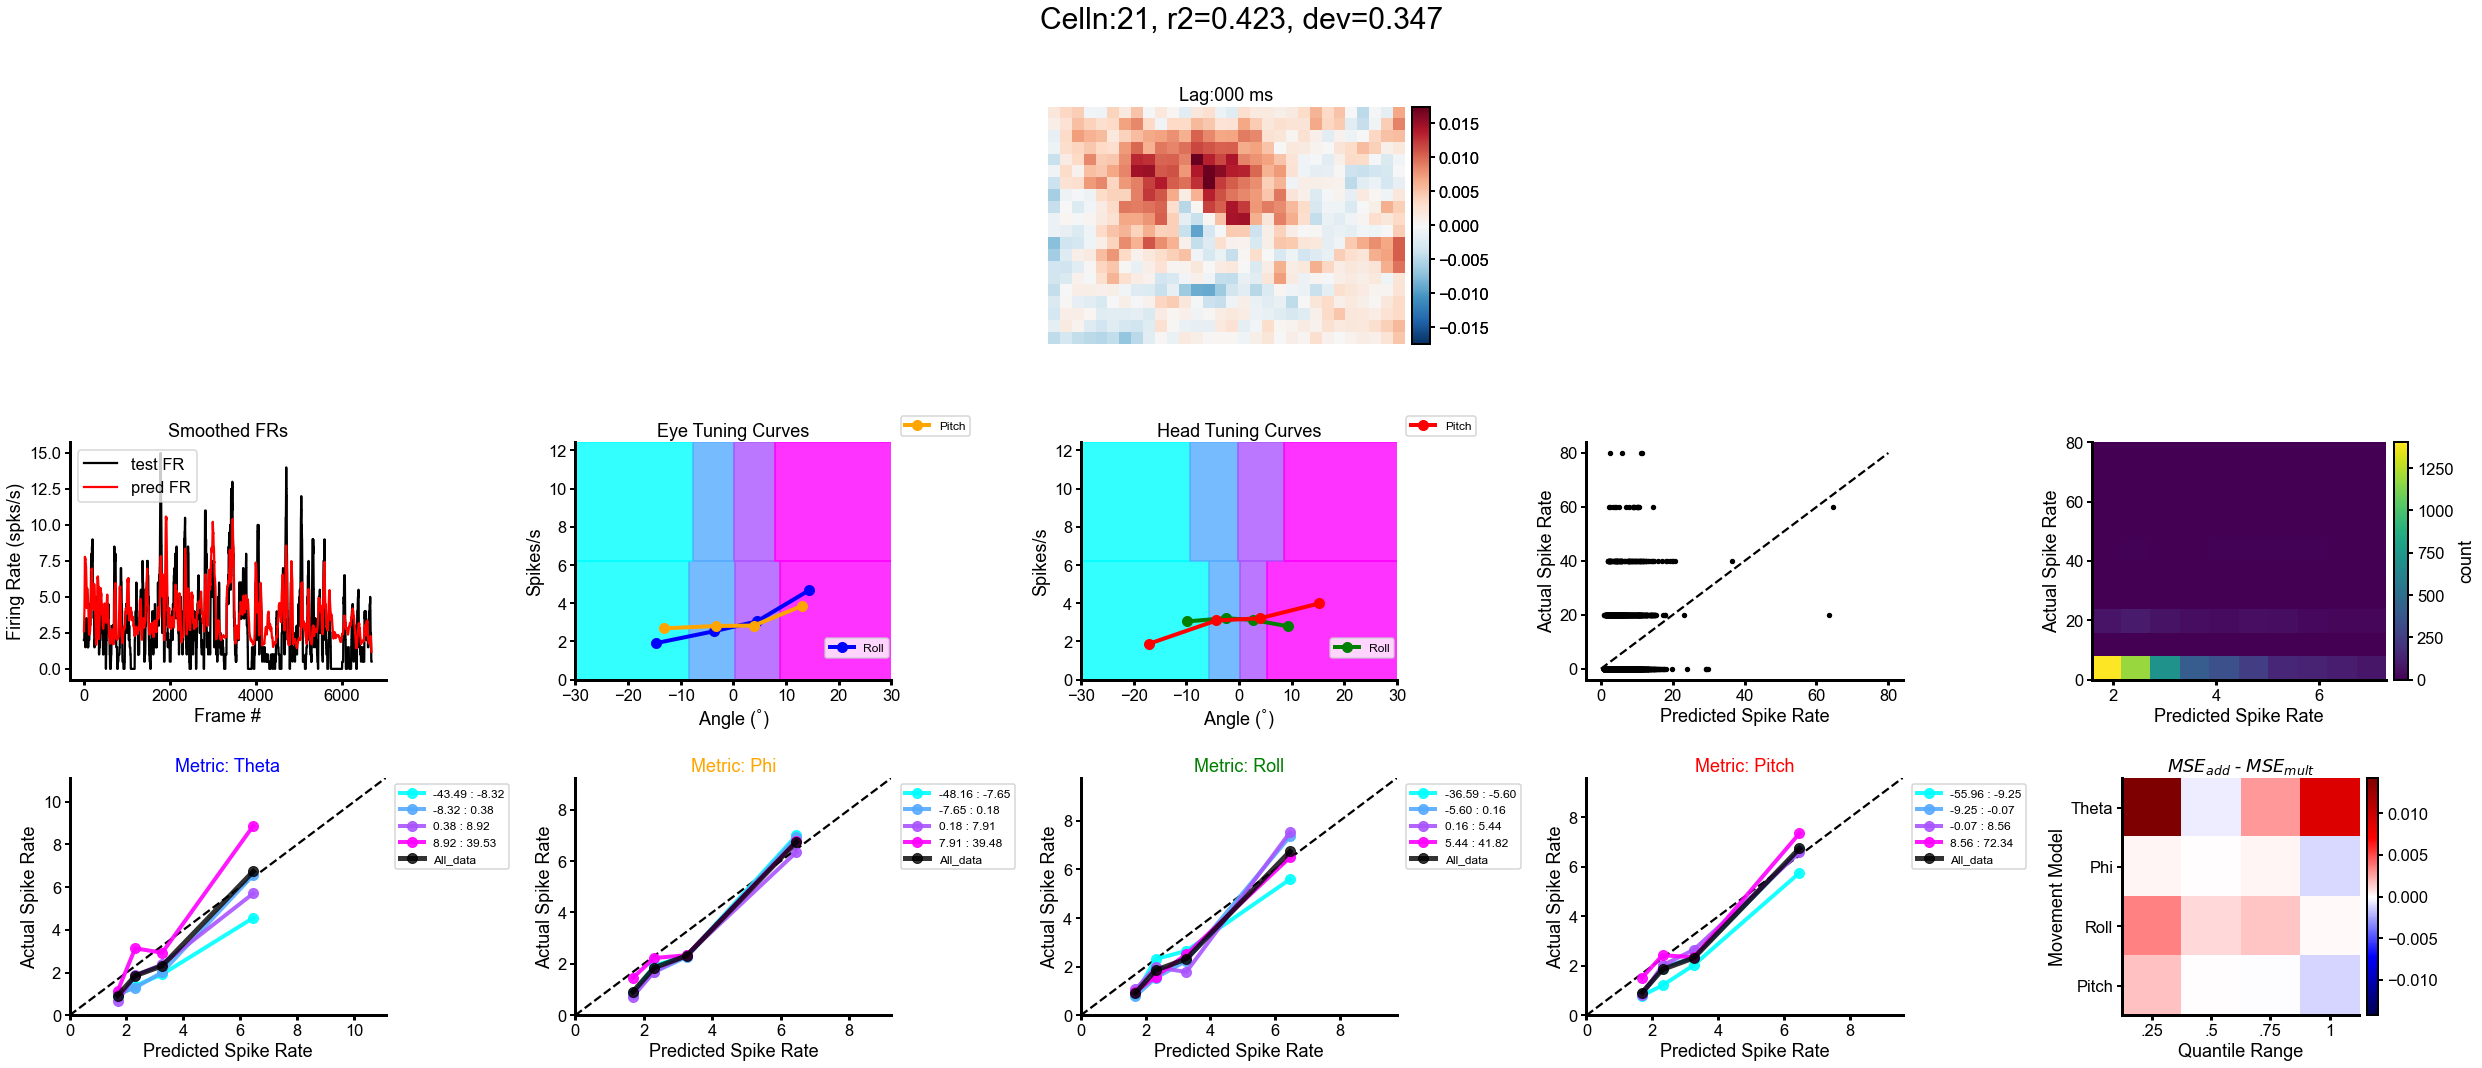

In [20]:
celln= 21 #np.argmax(mr2)
bin_length=40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# quartiles = np.arange(.1,1,.2)#[0,.25,.5,.75,1]
quartiles = np.arange(0,1.25,.25)
# lag=150 # in ms
# nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([0])# np.arange(-1,4,dtype=int) #np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
msp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(msp_smooth,'k',label='test FR')
axs[1,0].plot(pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Frame #')
axs[1,0].set_ylabel('Firing Rate (spks/s)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(msta[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(msta[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(mpred[celln]/model_dt,msp[celln]/model_dt,c='k',s=15)
axs[1,3].plot(np.linspace(msp_range[0],msp_range[1]),np.linspace(msp_range[0],msp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

hist,xedges,yedges,img =axs[1,4].hist2d(mpred[celln]/model_dt,msp[celln]/model_dt,range=np.vstack((pred_range,msp_range)))#pred_smooth,msp_smooth)
axs[1,4].set_xlabel('Predicted Spike Rate')
axs[1,4].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
cbar.set_label('count')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
    lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)

#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
#     axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}, dev={:.03f}'.format(celln,mcc[celln]**2,mr2[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
bin_length=40
cc_all = np.zeros(mpred.shape[0])
cc_all2 = np.zeros(mpred.shape[0])
for celln in range(mpred.shape[0]):
    msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
    pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
    cc_all[celln] = np.corrcoef(msp_smooth[bin_length:-bin_length],pred_smooth[bin_length:-bin_length])[0,1]
    cc_all2[celln] = np.corrcoef(msp_smooth,pred_smooth)[0,1]

In [ ]:
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

In [13]:
bin_length=40
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for model_dt in [.05]: #
    lag=150 # in ms
    nt_glm_lag = 5
#     minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
    lag_list = np.arange(-1,4,dtype=int) #np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
    nt_glm_lag = len(lag_list)
    if do_shuffle:
        GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
        locals().update(GLM_Vis_shuff)
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
        locals().update(GLM_Vis)
    
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    ##### Explore Neurons #####
    # Initialize movement combinations
    titles = np.array(['th','phi','roll','pitch']) # 'dg_p','dg_n' 'roll','pitch' 'dg_p','dg_n']) #
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    # move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis], train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    move_test = move_test - np.mean(move_test,axis=0)
    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.max(tuning,axis=1)
        var_ranges[modeln] = var_range
    cc_all = np.zeros(test_nsp.shape[1])
    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'Vis_GLM_{}_dt{:03d}_T{:02d}_cellsummary_sig_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    else:
        pdf_name = FigPath/ 'Vis_GLM_{}_dt{:03d}_T{:02d}_cellsummary_sig.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(msp.shape[0])):
            if mcc[celln]>.25:
                fig, axs = plt.subplots(3,5, figsize=((35,15))) 
                gs = axs[0,0].get_gridspec()
                gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
                for ax in axs[0,:]:
                    ax.remove()
                top_grid = np.zeros((nt_glm_lag),dtype=object)
                for ind in range(nt_glm_lag):
                    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

                predcell = mpred[celln]/model_dt
                nspcell = msp[celln]/model_dt
                msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
                pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
                # Set up predicted spike range between 1-99th percentile
                stat_bins = 5
                pred_range = np.quantile(predcell,[.1,.9])
                msp_range = np.quantile(nspcell,[.01,1])
                spike_percentiles = np.arange(0,1.25,.25)
                spike_percentiles[-1]=.99
                spk_percentile2 = np.arange(.125,1.125,.25)
                pred_rangelin = np.quantile(predcell,spike_percentiles)
                xbin_pts = np.quantile(predcell,spk_percentile2)
                stat_bins = len(pred_rangelin) #5


                axs[1,0].plot(msp_smooth,'k',label='test FR')
                axs[1,0].plot(pred_smooth,'r', label='pred FR')
                axs[1,0].set_xlabel('Frame #')
                axs[1,0].set_ylabel('Firing Rate (spks/s)')
                axs[1,0].legend()
                axs[1,0].set_title('Smoothed FRs')

                crange = np.max(np.abs(msta[celln]))
                for n in range(nt_glm_lag):
                    img = top_grid[n].imshow(msta[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
                    top_grid[n].axis('off')
                    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
                    top_grid[n].axis('off')
                add_colorbar(img)

                # Eye Tuning Curve
                top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
                for i,modeln in enumerate(range(len(titles)-2)):
                    metric = move_test[:,modeln]
                    nranges = np.quantile(metric,quartiles)
                    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
                axs[1,1].set_xlim(-30,30)
                axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
                axs[1,1].set_ylabel('Spikes/s')
                axs[1,1].set_title('Eye Tuning Curves')
                lines = axs[1,1].get_lines()
                legend1 = axs[1,1].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,1].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
                axs[1,1].add_artist(legend1)

                # Head Tuning Curves
                top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
                for i, modeln in enumerate(range(2,len(titles))):
                    metric = move_test[:,modeln]
                #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,2].set_ylim(bottom=0,top=top_yaxs)
                axs[1,2].set_xlim(-30,30)
                axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
                axs[1,2].set_ylabel('Spikes/s')
                axs[1,2].set_title('Head Tuning Curves')
                lines = axs[1,2].get_lines()
                legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
                axs[1,2].add_artist(legend1)

                # axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


                # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
                axs[1,3].scatter(mpred[celln]/model_dt,msp[celln]/model_dt,c='k',s=15)
                axs[1,3].plot(np.linspace(msp_range[0],msp_range[1]),np.linspace(msp_range[0],msp_range[1]),'k--',zorder=0)
                axs[1,3].set_xlabel('Predicted Spike Rate')
                axs[1,3].set_ylabel('Actual Spike Rate')
                cbar = add_colorbar(img)
                # cbar.set_label('count')

                hist,xedges,yedges,img =axs[1,4].hist2d(mpred[celln]/model_dt,msp[celln]/model_dt,range=np.vstack((pred_range,msp_range)))#pred_smooth,msp_smooth)
                axs[1,4].set_xlabel('Predicted Spike Rate')
                axs[1,4].set_ylabel('Actual Spike Rate')
                cbar = add_colorbar(img)
                cbar.set_label('count')


                mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

                traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
                edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
                for modeln in range(len(titles)):
                    metric = move_test[:,modeln]
                    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces_mean[celln,modeln]=stat_all
                    max_fr = np.max(stat_all)
                #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
                #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                    for n in range(len(nranges)-1):
                        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                        pred = predcell[ind]
                        sp = nspcell[ind]

                        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                        traces[celln,modeln,n]=stat_range
                        edges_all[celln,modeln,n]=edge_mids
                        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                        mse_add[celln, modeln, n] = res_add.fun
                        mse_mult[celln, modeln, n] = res_mult.fun
                        alpha_add[celln, modeln, n] = res_add.x
                        alpha_mult[celln, modeln, n] = res_mult.x

                        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                        axs[2,modeln].set_xlabel('Predicted Spike Rate')
                        axs[2,modeln].set_ylabel('Actual Spike Rate')

                    lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
                    lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
                    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

                    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
                #     axs[2,modeln].axis('equal')
                #     axs[2,modeln].set_xlim(left=0)
                    axs[2,modeln].set(xlim=lims, ylim=lims)

                #     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
                #     axs[2,modeln].set_ylim(bottom=0)

                dmodel = mse_add[celln]-mse_mult[celln]
                crange = np.max(np.abs(dmodel))
                im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
                axs[2,-1].set_yticks(np.arange(0,4))
                axs[2,-1].set_yticklabels(titles)
                axs[2,-1].set_ylabel('Movement Model')
                axs[2,-1].set_xticks(np.arange(0,4))
                axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
                axs[2,-1].set_xlabel('Quantile Range')
                axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
                cbar = add_colorbar(im)

                plt.suptitle('Celln:{}, r2={:.03f}, dev={:.03f}'.format(celln,mcc[celln]**2,mr2[celln]),y=1,fontsize=30)
                plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)
                pdf.savefig()
                plt.close()

    # fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


  0%|          | 0/128 [00:00<?, ?it/s]

### Shuffle Comparison

In [124]:
GLM_Vis_shuff['mcc']**2

array([1.65629333e-03, 1.24968865e-04, 5.05795705e-03, 6.54336715e-03,
       6.02062343e-03, 3.68269506e-04, 5.90389508e-03, 8.41303778e-03,
       1.54218697e-03, 1.77727648e-02, 5.84892629e-03, 2.67828324e-04,
       1.18656275e-02, 1.22218410e-03, 9.56037518e-04, 1.11808733e-04,
       1.13038752e-02, 1.59461363e-03, 2.41869482e-04, 1.18716604e-02,
       9.40998029e-03, 4.09114005e-04, 6.65866640e-03, 4.18699543e-04,
       2.51806437e-03, 5.33836172e-05, 3.47693742e-03, 7.87448667e-07,
       1.16750649e-02, 1.44043459e-03, 8.17317873e-04, 8.90747469e-04,
       6.97498659e-03, 6.84408011e-03, 1.15253173e-03, 1.69094647e-03,
       3.21051330e-03, 1.57672193e-02, 8.81927475e-03, 5.04855054e-06,
       9.86375812e-04, 8.62543177e-03, 5.16627612e-03, 5.42630227e-04,
       1.85406733e-05, 1.81809791e-02, 3.52835096e-03, 8.11855837e-03,
       8.91342469e-03, 1.96578683e-02, 8.07672381e-04, 1.07086929e-02,
       6.28601656e-06, 2.82331562e-03, 3.73180674e-03, 3.64370561e-03,
      

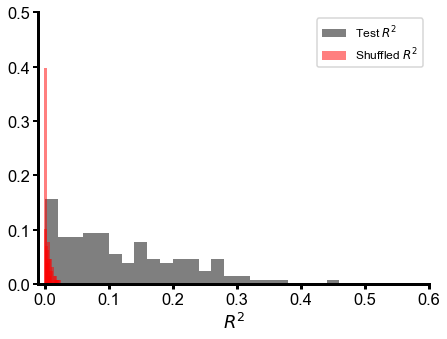

In [11]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)

count,edges = np.histogram((GLM_Vis['mcc'])**2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram((GLM_Vis_shuff['mcc'])**2,bins=np.arange(0,1,.001))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='Test $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.005,alpha=.5, label='Shuffled $R^2$')
ax.set_xlabel('$R^2$')

# ax.set_ylabel('Proportion')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.6)
ax.set_ylim(0,.5)
ax.legend(fontsize=12)

# count,edges = np.histogram(GLM_Vis['mr2'],bins=np.arange(-.2,1,.05))
# count_shuff,edges_shuff = np.histogram(GLM_Vis_shuff['mr2'],bins=np.arange(-.2,1,.05))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# ax[1].bar(edges_mid, count/len(GLM_Vis['mr2']),color='k',width=.05,alpha=.5,label='Test $r^2$')
# ax[1].bar(edges_mid, count_shuff/len(GLM_Vis['mr2']),color='r',width=.05,alpha=.5,label='Shuffled $r^2$')
# ax[1].set_xlabel('Corr. Coef.')
# ax[1].set_ylabel('Proportion')
# ax[1].set_xlim(-.2,.75)
# ax[1].set_ylim(0,.7)
# ax[1].legend(fontsize=12)
# plt.suptitle('model_dt={:03d}ms'.format(int(model_dt*1000)),fontsize=20)
# plt.tight_layout()
# fig.savefig(FigPath/'R2_comparison_VisOnly_notsmooth_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

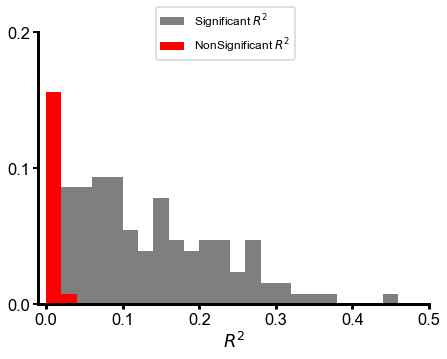

In [28]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
max_shuff = np.max(GLM_Vis_shuff['mcc']**2)
mr2 = (GLM_Vis['mcc'])**2
fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = mr2[mr2>max_shuff]
non_sig = mr2[mr2<max_shuff]

count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,.02))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='Significant $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.02,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))

# count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
# count_shuff,edges_shuff = np.histogram((GLM_Vis_shuff['mcc'])**2,bins=np.arange(0,1,.001))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])

# axins = inset_axes(ax, width=5, height=2)
# axins.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='Test $R^2$')
# axins.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.001,alpha=.5, label='Shuffled $R^2$')
# axins.set_xlabel('$R^2$')
# axins.set_yticks(np.arange(0,1,.1))
# axins.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
# axins.set_xlim(-.001,.04)
# axins.set_ylim(0,.5)
# # axins.legend(fontsize=12)

fig.savefig(FigPath/'R2_comparison_VisOnly_signonsig_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

In [160]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


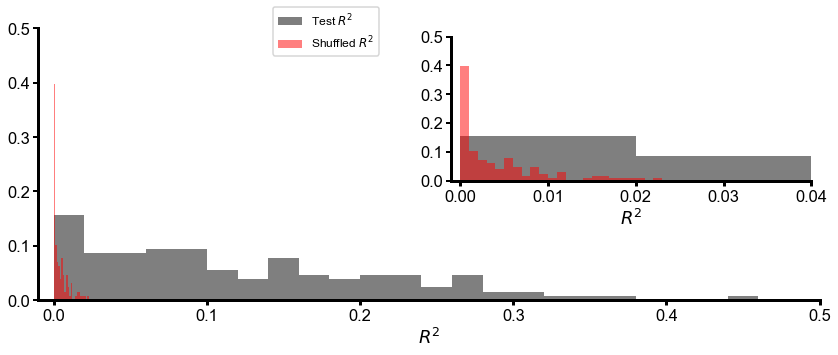

In [172]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
max_shuff = np.max(GLM_Vis_shuff['mcc']**2)
mr2 = (GLM_Vis['mcc'])**2
fig,ax = plt.subplots(1,1,figsize=(14,5))

sig = mr2[mr2>max_shuff]
count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram((GLM_Vis_shuff['mcc'])**2,bins=np.arange(0,1,.001))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='Test $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.001,alpha=.5, label='Shuffled $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.5)
ax.legend(fontsize=12,loc=(.3,.9))

non_sig = mr2[mr2<max_shuff]
count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram((GLM_Vis_shuff['mcc'])**2,bins=np.arange(0,1,.001))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])

axins = inset_axes(ax, width=5, height=2)
axins.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='Test $R^2$')
axins.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.001,alpha=.5, label='Shuffled $R^2$')
axins.set_xlabel('$R^2$')
axins.set_yticks(np.arange(0,1,.1))
axins.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
axins.set_xlim(-.001,.04)
axins.set_ylim(0,.5)
# axins.legend(fontsize=12)

# fig.savefig(FigPath/'R2_comparison_VisOnly_notsmooth_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
n = 1
model_n=-1
celln=51
# for modeln in range(len(titles)):
traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
metric = move_test[:,modeln]
nranges = np.quantile(metric,[0,.25,.5,.75,1])# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
edge_mids = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))
#     for n in range(len(nranges)-1):
ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
pred = predcell[ind]
sp = nspcell[ind]

stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
edge_mids = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
traces_mean[celln,modeln]=stat_all

traces[celln,modeln,n]=stat_range
edges_all[celln,modeln,n]=edge_mids
res_add = minimize_scalar(f_add,args=(stat_range,stat_all))
res_mult = minimize_scalar(f_mult,args=(stat_range,stat_all))
mse_add[celln, modeln, n] = res_add.fun
mse_mult[celln, modeln, n] = res_mult.fun
alpha_add[celln, modeln, n] = res_add.x
alpha_mult[celln, modeln, n] = res_mult.x
        
#         axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20)
#         axs[1,modeln].plot(np.linspace(pred_range[0],pred_range[1]),np.linspace(pred_range[0],pred_range[1]),'k--',zorder=0)
#         axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
#         axs[1,modeln].set_xlabel('Predicted Spike Rate')
#         axs[1,modeln].set_ylabel('Actual Spike Rate')
#     axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data')
#     axs[1,modeln].legend(loc='upper left', fontsize=12)
#     axs[1,modeln].axis('equal')


In [ ]:
res_add = minimize_scalar(f_add,args=(stat_range,stat_all),tol=1e-6)
res_mult = minimize_scalar(f_mult,args=(stat_range,stat_all),tol=1e-6)
mse_add[celln,modeln, n] = res_add.fun
mse_mult[celln,modeln, n] = res_mult.fun
alpha_add[celln,modeln, n] = res_add.x
alpha_mult[celln,modeln, n] = res_mult.x

In [ ]:
res_mult.x,alpha_mult[celln,modeln, n] 

In [ ]:
res_add,res_mult

In [ ]:
alpha_add[celln,modeln,n],alpha_mult[celln,modeln,n]

In [ ]:
mse_add[celln,modeln, n], mse_mult[celln,modeln, n]

In [ ]:

plt.figure(figsize=(8,8))
plt.plot(edge_mids,traces_mean[celln,modeln],'.-', c='k', lw=5, ms=20, label='All_data')
plt.plot(edge_mids,(traces_mean[celln,modeln]*alpha_mult[celln,modeln,n]).T,'--', label='MultFit',c=colors[n],lw=4,ms=20)
plt.plot(edge_mids,(traces_mean[celln,modeln]+alpha_add[celln,modeln,n]).T,'-.', label='AddFit', c=colors[n],lw=4,ms=20)
plt.plot(edge_mids, traces[celln,modeln,n],'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20)
plt.legend()

In [ ]:
alphas = np.arange(-10,10,.001)
mse_add = np.zeros(alphas.shape[0])
mse_mult = np.zeros(alphas.shape[0])
for ind,alpha in enumerate(alphas):
    mse_add[ind] = np.mean((stat_range - stat_all+alpha)**2)
    mse_mult[ind] = np.mean((stat_range - stat_all*alpha)**2)

In [ ]:
np.min(mse_add),np.min(mse_mult)

In [ ]:
plt.plot(mse_add)
plt.plot(mse_mult)

In [ ]:
plt.plot(stat_all+alphas[np.argmin(mse_add)])
plt.plot(stat_all+alphas[np.argmin(mse_mult)])
plt.plot(stat_all, 'k')

In [ ]:
fig, axs = plt.subplots(figsize=(5,5))
crange = np.max(np.abs(min_add-min_mult))
im = axs.imshow(min_add-min_mult,cmap='seismic',vmin=-crange,vmax=crange,origin='lower')
axs.set_yticks(np.arange(0,4))
axs.set_yticklabels(titles)
axs.set_ylabel('Movement Model')
axs.set_xticks(np.arange(0,4))
axs.set_xticklabels(['.25','.5','.75','1'])
axs.set_xlabel('Quantile Range')
axs.set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)


### Animations

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
celln=117
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
ymax = np.max(np.maximum(msp_smooth, pred_smooth))
ymin = np.min(np.minimum(msp_smooth, pred_smooth))

In [ ]:
sf = 4
model_vid = np.zeros((test_vid.shape[0],sf*test_vid.shape[1],sf*test_vid.shape[2]))
for n in range(test_vid.shape[0]):
    model_vid[n] = cv2.resize(test_vid[n],(sf*test_vid.shape[2],sf*test_vid.shape[1]))

In [ ]:
t0=0
dt=3000
fig = make_subplots(rows=1, cols=2,)

fig.add_trace(go.Scatter(x=np.arange(t0,t0+dt)*model_dt,y=msp_smooth[t0:t0+dt], mode='lines', name='Test FR'),row=1,col=2)
fig.add_trace(go.Scatter(x=np.arange(t0,t0+dt)*model_dt,y=pred_smooth[t0:t0+dt], mode='lines', name='Pred FR'),row=1,col=2)
fig.add_trace(go.Scatter(x=[t0*model_dt, t0*model_dt], y=[ymin-1, ymax+1], mode='lines', line_color='red', line_width=2, showlegend=False),row=1,col=2)
fig.add_trace(go.Heatmap(z=model_vid[t0], colorscale='gray', showscale=False),row=1, col=1)


frames = []
for t in np.arange(t0,t0+dt,10):
    frames.append(dict(name='{}'.format(t),data=[go.Scatter(x=np.arange(t0,t0+dt)*model_dt,y=msp_smooth[t0:t0+dt],mode='lines',name='Test FR'),
                                go.Scatter(x=np.arange(t0,t0+dt)*model_dt,y=pred_smooth[t0:t0+dt], mode='lines', name='Pred FR'),
                                go.Scatter(x=[t*model_dt, t*model_dt], y=[ymin-1, ymax+1], mode='lines', line_color='red', line_width=2, showlegend=False),
                                go.Heatmap(z=model_vid[t], colorscale='gray',showscale=False)
                               ], 
                          traces=[0,1,2,3],
                         )
                )
fig.frames=frames
# Slider
sliders = [{'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {'font': {'size': 16}, 'prefix': 'Frame: ', 'visible': True, 'xanchor': 'right'},
            'transition': {'duration': 0, 'easing': 'linear'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9, 'x': 0.1, 'y': 0,
            'steps': [{'args': [[k], {'frame': {'duration': 0, 'easing': 'linear', 'redraw': True},
                                      'transition': {'duration': 0, 'easing': 'linear'}}],
                       'label': '{}'.format(k), 'method': 'animate'} for k in np.arange(t0,t0+dt,10)
                      ]}]


axis_template = dict(autorange = True,
             showgrid = False, zeroline = False,
             linecolor = 'black', showticklabels = False,
             ticks = '' )
fig.update_layout(width=1000,
                  height=500,
                 xaxis=axis_template,
                 yaxis=axis_template,
                 sliders=sliders
                 )
fig.update_yaxes(autorange="reversed",row=1,col=1)

fig.show() 


### Head Fixed Plots

In [ ]:
celln = 25# np.argmax(mcc)
bin_length=40

fig, axs = plt.subplots(1,nt_glm_lag+1,figsize=(30,5))
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
axs[0].plot(msp_smooth,'k',label='test FR')
axs[0].plot(pred_smooth,'r', label='pred FR')
axs[0].set_xlabel('Frame #')
axs[0].set_ylabel('Firing Rate (spks/s)')
axs[0].legend()
axs[0].set_title('Smoothed FRs')

crange = np.max(np.abs(msta[celln]))
for axn,n in enumerate(range(1,nt_glm_lag+1)):
    img = axs[n].imshow(msta[celln,axn],cmap='RdBu_r',vmin=-crange,vmax=crange)
    axs[n].axis('off')
    axs[n].set_title('Lag: {}ms'.format(int(1000*lag_list[axn]*model_dt)))
cbar = add_colorbar(img,) # orientation='horizontal',location='bottom'
# cbar.set_ticks([-crange,crange])
# cbar.set_ticklabels(['Dark','Light'])
plt.suptitle('Celln:{}, cc={:.03f}, r2={:.03}'.format(celln,mcc[celln],mr2[celln]),y=.9,fontsize=20)
plt.tight_layout()

In [ ]:
with PdfPages(FigPath/ 'GLM_{}_dt{:03d}_T{:02d}_cellsummary_sig.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)) as pdf:
    for celln in tqdm(range(msp.shape[0])):
        if mcc[celln]>.25:
            fig, axs = plt.subplots(1,nt_glm_lag+1,figsize=(30,5))
            predcell = mpred[celln]/model_dt
            nspcell = msp[celln]/model_dt
            msp_smooth=((np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            pred_smooth=((np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            axs[0].plot(msp_smooth,'k',label='test FR')
            axs[0].plot(pred_smooth,'r', label='pred FR')
            axs[0].set_xlabel('Frame #')
            axs[0].set_ylabel('Firing Rate (spks/s)')
            axs[0].legend()
            axs[0].set_title('Smoothed FRs')

            crange = np.max(np.abs(msta[celln]))
            for axn,n in enumerate(range(1,nt_glm_lag+1)):
                img = axs[n].imshow(msta[celln,axn],cmap='RdBu_r',vmin=-crange,vmax=crange)
                axs[n].axis('off')
                axs[n].set_title('Lag: {}ms'.format(int(1000*lag_list[axn]*model_dt)))
            cbar = add_colorbar(img,) # orientation='horizontal',location='bottom'
            # cbar.set_ticks([-crange,crange])
            # cbar.set_ticklabels(['Dark','Light'])
            plt.suptitle('Celln:{}, cc={:.03f}, r2={:.03}'.format(celln,mcc[celln],mr2[celln]),y=.9,fontsize=20)
            plt.tight_layout()
            
            pdf.savefig()
            plt.close()
# fig.savefig(FigPath/'TemporalRF_N{}.pdf'.format(celln), facecolor='white', transparent=True)

## Modulate FR

In [1]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [56]:
celln = 126
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)

In [57]:
# modeln = 0
modeln = 0#np.argmax(tc_mod[celln])
print('Metric:',titles[modeln])
metric = move_test[:,modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric ,test_nsp[:,celln], statistic='mean',bins=nranges)
edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# for m in range(len(nranges)-1):
#     axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)

Metric: Theta


In [58]:
np.unravel_index(np.argmax(dmodel),dmodel.shape)

(1, 0)

In [59]:
alpha_mult[celln,modeln]

array([0., 0., 0., 0.])

In [65]:

tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.min(tuning_curves,axis=-1,keepdims=True)+np.max(tuning_curves,axis=-1,keepdims=True))

avg_fr = np.mean(tuning_curves,axis=-1).squeeze()

thresh_fr = 2
tuning_sig = tc_mod.copy()
tuning_sig[avg_fr[:,modeln]<thresh_fr] = 0
dmodel[avg_fr[:,modeln]<thresh_fr]=0

In [61]:
tuning_sig.shape

(128, 4, 1)

In [62]:
np.argmax(np.mean(tuning_sig,axis=(-1,-2))),tuning_sig[np.argmax(tuning_sig[:,0])]

(74,
 array([[1.        ],
        [0.55688623],
        [0.36524253],
        [1.        ]]))

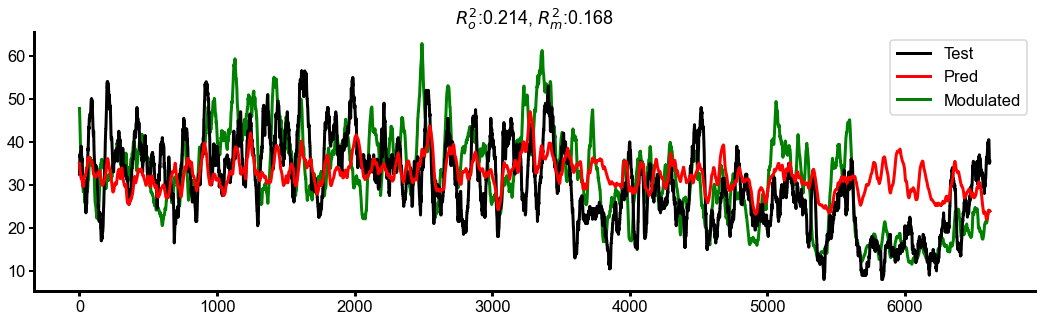

In [68]:
t = bin_length
dt = len(msp_smooth)-2*bin_length
celln = 126
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(msp_smooth[t:t+dt], color='k',lw=3,label='Test')
ax.plot(pred_smooth[t:t+dt], color='r',lw=3,label='Pred')
pred_smooth_mult = pred_smooth.copy()
pred_mult = mpred[celln].copy()
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric ,test_nsp[:,celln], statistic='mean',bins=nranges)
    metric2 = metric[t:t+dt]
    for i in range(len(edges)-1):    
        metric_bounds = consecutive(np.where((metric2>edges[i])&(metric2<edges[i+1]))[0])
        metric_bounds = [row for row in metric_bounds]
        metric_length = [len(row) for row in metric_bounds]
    #     print(i,np.sum(metric_length))
        # n=1
    #     plt.axvspan(metric_bounds[n][0],metric_bounds[n][-1], color=colors[i],zorder=0)
    #     print(metric_bounds[n])
        for n, row in enumerate(metric_bounds):
#             ax.axvspan(metric_bounds[n][0],metric_bounds[n][-1], color=colors[i], zorder=0)
            pred_smooth_mult[row] = alpha_mult[celln,modeln,i]*pred_smooth_mult[row]
            pred_mult[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
# ax.plot(pred_smooth_mult[t:t+dt],'g',lw=3,zorder=1,label='Modulated')
ax.plot(((np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt))[t:t+dt],'g',lw=3,zorder=1,label='Modulated')

cc_mult = np.corrcoef(msp_smooth[bin_length:-bin_length],pred_smooth_mult[bin_length:-bin_length])[0,1]
ax.set_title('$R^2_o$:{:.03f}, $R^2_m$:{:.03f}'.format(mcc[celln]**2,cc_mult**2))
plt.legend()
plt.tight_layout()

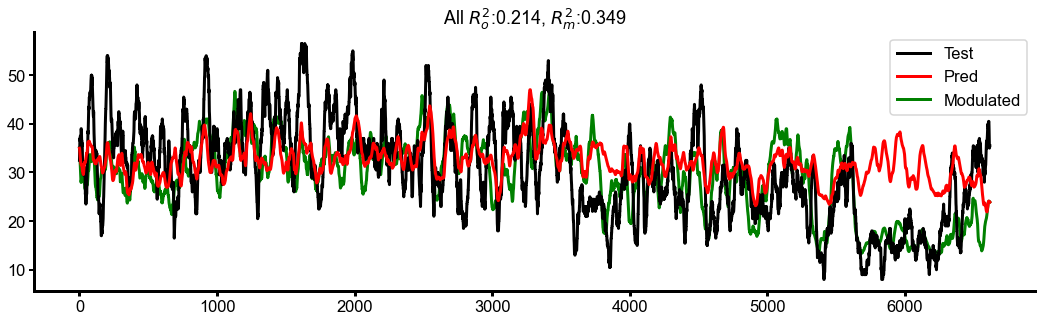

In [74]:
t = bin_length
dt = len(msp_smooth)-2*bin_length
celln = 126
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(msp_smooth[t:t+dt], color='k',lw=3,label='Test')
# ax.plot(pred_smooth[t:t+dt], color='r',lw=3,label='Pred')
# pred_smooth_mult = pred_smooth.copy()
# pred_mult = mpred[celln].copy()
pdf_name = FigPath/ 'ModulatedFR_{}_dt{:03d}_T{:02d}_cellsummary_sig.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
with PdfPages(pdf_name) as pdf:
    for modeln in range(len(titles)):
        fig, ax = plt.subplots(figsize=(15,5))
        ax.plot(msp_smooth[t:t+dt], color='k',lw=3,label='Test')
        ax.plot(pred_smooth[t:t+dt], color='r',lw=3,label='Pred')
        pred_smooth_mult = pred_smooth.copy()
        pred_mult = mpred[celln].copy()
        pred_mult_all = mpred[celln].copy()
        metric = move_test[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric ,test_nsp[:,celln], statistic='mean',bins=nranges)
        metric2 = metric[t:t+dt]
        for i in range(len(edges)-1):    
            metric_bounds = consecutive(np.where((metric2>edges[i])&(metric2<edges[i+1]))[0])
            metric_bounds = [row for row in metric_bounds]
            metric_length = [len(row) for row in metric_bounds]
        #     print(i,np.sum(metric_length))
            # n=1
        #     plt.axvspan(metric_bounds[n][0],metric_bounds[n][-1], color=colors[i],zorder=0)
        #     print(metric_bounds[n])
            for n, row in enumerate(metric_bounds):
    #             ax.axvspan(metric_bounds[n][0],metric_bounds[n][-1], color=colors[i], zorder=0)
                pred_mult[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
                pred_mult_all[row] = alpha_mult[celln,modeln,i]*pred_mult[row]
    # ax.plot(pred_smooth_mult[t:t+dt],'g',lw=3,zorder=1,label='Modulated')
        pred_smooth_mult = (np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt)
        ax.plot(pred_smooth_mult[t:t+dt],'g',lw=3,zorder=1,label='Modulated')
        cc_mult = np.corrcoef(msp_smooth[bin_length:-bin_length],pred_smooth_mult[bin_length:-bin_length])[0,1]
        ax.set_title('metric:{}, $R^2_o$:{:.03f}, $R^2_m$:{:.03f}'.format(titles[modeln],mcc[celln]**2,cc_mult**2))
        plt.legend()
        plt.tight_layout()
        pdf.savefig()
        plt.close()
        
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(msp_smooth[t:t+dt], color='k',lw=3,label='Test')
    ax.plot(pred_smooth[t:t+dt], color='r',lw=3,label='Pred')
    pred_smooth_mult_all = (np.convolve(pred_mult, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    ax.plot(pred_smooth_mult_all[t:t+dt],'g',lw=3,zorder=1,label='Modulated')

    cc_mult = np.corrcoef(msp_smooth[bin_length:-bin_length],pred_smooth_mult_all[bin_length:-bin_length])[0,1]
    ax.set_title('All $R^2_o$:{:.03f}, $R^2_m$:{:.03f}'.format(mcc[celln]**2,cc_mult**2))
    plt.legend()
    plt.tight_layout()
    pdf.savefig()

In [58]:
alpha_mult.shape

(128, 4, 4)

## Plots for Figures

In [11]:
bin_length=40
lag=150 # in ms
nt_glm_lag = 5
stat_bins = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([0]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
##### Explore Neurons #####
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
# move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis], train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

quartiles = np.arange(0,1.25,.25)
mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
for celln in tqdm(range(msp.shape[0])):

        predcell = mpred[celln]/model_dt
        nspcell = msp[celln]/model_dt
        msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
        pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)


        # axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)

        # Set up predicted spike range between 1-99th percentile
        stat_bins = 5
        pred_range = np.quantile(predcell,[.1,.9])
        msp_range = np.quantile(nspcell,[.01,1])
        spike_percentiles = np.arange(0,1.25,.25)
        spike_percentiles[-1]=.99
        spk_percentile2 = np.arange(.125,1.125,.25)
        pred_rangelin = np.quantile(predcell,spike_percentiles)
        xbin_pts = np.quantile(predcell,spk_percentile2)
        stat_bins = len(pred_rangelin) #5
        # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)

        for modeln in range(len(titles)):
            metric = move_test[:,modeln]
            nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
            stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
            edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
            traces_mean[celln,modeln]=stat_all
            max_fr = np.max(stat_all)

            for n in range(len(nranges)-1):
                ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                pred = predcell[ind]
                sp = nspcell[ind]

                stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                traces[celln,modeln,n]=stat_range
                edges_all[celln,modeln,n]=edge_mids
                res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                mse_add[celln, modeln, n] = res_add.fun
                mse_mult[celln, modeln, n] = res_mult.fun
                alpha_add[celln, modeln, n] = res_add.x
                alpha_mult[celln, modeln, n] = res_mult.x

dmodel = mse_add-mse_mult

# fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


  0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
plt.plot((tuning_curves[51,3]))

In [ ]:
from scipy.signal import find_peaks,find_peaks_cwt

In [ ]:
pk_info = find_peaks_cwt(tuning_curves[51,3],widths=[1,2])

In [ ]:
pk_info,tuning_curves[51,3]

In [ ]:
mod_index = (tuning_curves[:,:,-1] - tuning_curves[:,:,0])/np.max(np.abs(tuning_curves),axis=-1)
mod_index[34]

### Freely Moving

In [12]:
model_dt=.05
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
# lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'

# for model_dt in [.025,.05,.1]:
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)


[0] [0.]


In [13]:
sf = 4
msta_up = np.zeros((msta.shape[0],msta.shape[1],sf*msta.shape[-2],sf*msta.shape[-1]))
for n in range(msta.shape[0]):
    for t in range(msta.shape[1]):
        msta_up[n,t] = cv2.resize(msta[n,t],(sf*msta.shape[-1],sf*msta.shape[-2]))


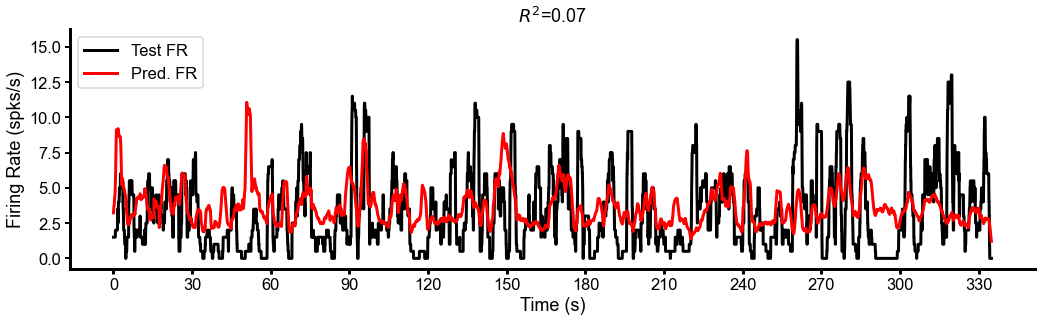

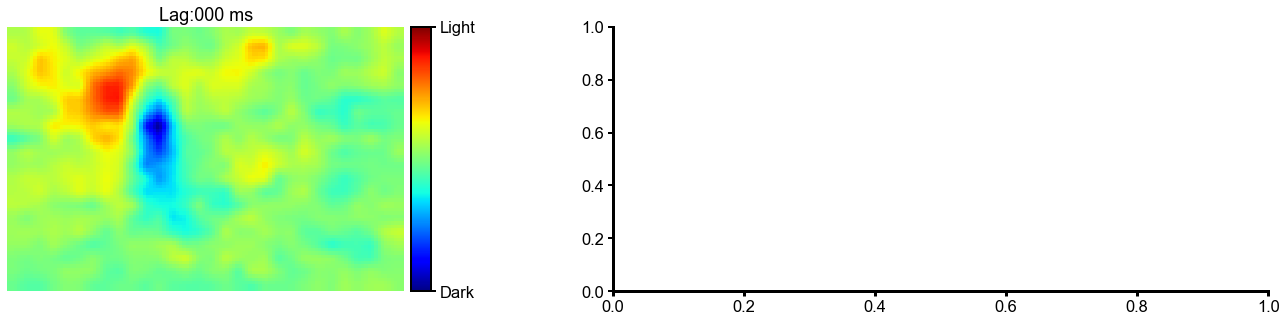

In [15]:
celln= 25 #np.argmax(mcc)
bin_length=40
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# quartiles = np.arange(.1,1,.2)#[0,.25,.5,.75,1]
quartiles = np.arange(0,1.25,.25)
lag=150 # in ms
nt_glm_lag = 5
# # minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([0])# np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)

fig, axs = plt.subplots(1,1, figsize=((15,5))) 

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
axs.plot(np.arange(len(msp_smooth))*model_dt,msp_smooth,'k',lw=3, label='Test FR')
axs.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r',lw=3, label='Pred. FR')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing Rate (spks/s)')
axs.set_xticks(np.arange(0,len(pred_smooth)*model_dt,30))
axs.legend()
# axs.set_title('Smoothed FRs')
axs.set_title('$R^2$={:.02f}'.format(GLM_Vis['mcc'][celln]**2))
plt.tight_layout()
fig.savefig(FigPath/'Example_TestPred_{}_Cell{}_singleLag.pdf'.format(stim_type,celln), facecolor='white', transparent=True)

fig, axs = plt.subplots(1,2, figsize=((20,5))) 
crange = np.max(np.abs(msta[celln]))
for n in range(nt_glm_lag):
    img = axs[n].imshow(msta_up[celln,n],cmap='jet',vmin=-crange,vmax=crange)
    axs[n].axis('off')
    axs[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    axs[n].axis('off')
cbar = add_colorbar(img)
cbar.set_ticks([-crange,crange])
cbar.set_ticklabels(['Dark','Light'])
plt.tight_layout()
fig.savefig(FigPath/'Example_STA_temporal_{}_Cell{}_singleLag_jet.pdf'.format(stim_type,celln), facecolor='white', transparent=True)


In [ ]:
celln = 21
modeln=0
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
fig, axs = plt.subplots(1,2,figsize=(12,5))
# Eye Tuning Curve
ax = axs[0]
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
metric = move_test[:,modeln]
nranges = np.quantile(metric,quartiles)
stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
for m in range(len(nranges)-1):
    ax.axvspan(nranges[m], nranges[m+1],alpha=0.8, color=colors[m],zorder=0)
#     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
ax.plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
ax.set_xlim(-30,30)
ax.set_xlabel('Angle ($ ^{\degree}$)')
ax.set_ylabel('Spikes/s')
ax.set_title('Eye Tuning Curves')
lines = ax.get_lines()
legend1 = ax.legend([lines[0]],['th'],bbox_to_anchor=(1.01, .2), fontsize=12)
# legend2 = axs.legend([lines[1]],['phi'],bbox_to_anchor=(1.01, 1), fontsize=12)
ax.add_artist(legend1)

spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)

mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))


metric = move_test[:,modeln]
nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
traces_mean[celln,modeln]=stat_all
ax = axs[1]
max_fr = np.max(stat_all)
for n in range(len(nranges)-1):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
    mse_add[celln, modeln, n] = res_add.fun
    mse_mult[celln, modeln, n] = res_mult.fun
    alpha_add[celln, modeln, n] = res_add.x
    alpha_mult[celln, modeln, n] = res_mult.x

    ax.plot(edge_mids, stat_range,'.-', c=colors[n],label='{:d} : {:d}'.format(int(nranges[n]),int(nranges[n+1])),lw=4,ms=20,alpha=.9)
    ax.set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
    ax.set_xlabel('Predicted Spike Rate')
    ax.set_ylabel('Actual Spike Rate')

lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
ax.legend(bbox_to_anchor=(1.01, .8), fontsize=12)
ax.set(xlim=lims, ylim=lims)
ax.set_xticks(np.arange(0,lims[-1],10))
plt.tight_layout()
# fig.savefig(FigPath/'Example_mult{}.png'.format(stim_type), facecolor='white', transparent=True)


In [ ]:
celln = 121
modeln=0
quartiles = np.arange(0,1.25,.25)
angn=4

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
fig, axs = plt.subplots(1,2,figsize=(12,5))


# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
metric = move_test[:,modeln]
nranges = np.quantile(var_ranges[modeln],quartiles)
cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=cmap.N)
ax = axs[0]
img = ax.imshow(np.round(nranges,decimals=1)[None,:angn],aspect='auto', origin='lower',cmap=cmap,norm=norm,extent=(nranges[0],nranges[angn],0,top_yaxs),alpha=.8)
ax.errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
ax.set_xlim(-50,50)
ax.set_xlabel('Angle ($ ^{\degree}$)')
ax.set_ylabel('Spikes/s')
ax.set_title('Eye Tuning Curves')
ax.legend(bbox_to_anchor=(1.01, .2), fontsize=12)

# lines = ax.get_lines()
# legend1 = ax.legend([lines[0]],titles[0],bbox_to_anchor=(1.01, .2), fontsize=12)
# legend2 = axs.legend([lines[1]],['phi'],bbox_to_anchor=(1.01, 1), fontsize=12)
# ax.add_artist(legend1)

spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)

mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))


metric = move_test[:,modeln]
nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
traces_mean[celln,modeln]=stat_all
ax = axs[1]
max_fr = np.max(stat_all)
for n in range(angn):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces[celln,modeln,n]=stat_range
    edges_all[celln,modeln,n]=edge_mids
    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
    mse_add[celln, modeln, n] = res_add.fun
    mse_mult[celln, modeln, n] = res_mult.fun
    alpha_add[celln, modeln, n] = res_add.x
    alpha_mult[celln, modeln, n] = res_mult.x
    ax.plot(edge_mids, stat_range,'.-', c=colors[n],label='{:d}$\degree$ : {:d}$\degree$'.format(int(nranges[n]),int(nranges[n+1])),lw=4,ms=20,alpha=.9)
ax.set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
ax.set_xlabel('Predicted Spike Rate')
ax.set_ylabel('Actual Spike Rate')

lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
ax.legend(bbox_to_anchor=(1.01, .8), fontsize=12)
ax.set(xlim=lims, ylim=lims)
ax.set_xticks(np.arange(0,lims[-1],10))
plt.tight_layout()
# fig.savefig(FigPath/'Example_mult_{}_midang4.png'.format(stim_type), facecolor='white', transparent=True)


In [ ]:
angn=1
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5

traces = np.zeros((len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)

mse_add = np.zeros((len(titles),len(quartiles)-1))
mse_mult = np.zeros((len(titles),len(quartiles)-1))
alpha_add = np.zeros((len(titles),len(quartiles)-1))
alpha_mult = np.zeros((len(titles),len(quartiles)-1))


metric = move_test[:,modeln]
nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
traces_mean[modeln]=stat_all
fig, ax = plt.subplots(figsize=(8,5))
max_fr = np.max(stat_all)
for n in range(angn):
    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
    pred = predcell[ind]
    sp = nspcell[ind]
    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces[modeln,n]=stat_range
    edges_all[modeln,n]=edge_mids
    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
    mse_add[modeln, n] = res_add.fun
    mse_mult[modeln, n] = res_mult.fun
    alpha_add[modeln, n] = res_add.x
    alpha_mult[modeln, n] = res_mult.x
    ax.plot(edge_mids, stat_range,'.-', c=colors[n],label='{:d}$\degree$ : {:d}$\degree$'.format(int(nranges[n]),int(nranges[n+1])),lw=4,ms=20,alpha=.9)
ax.set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
ax.set_xlabel('Predicted Spike Rate')
ax.set_ylabel('Actual Spike Rate')

lim_max = np.max(traces[modeln])+np.std(traces_mean[modeln])
lim_min = np.min(traces[modeln])-np.std(traces_mean[modeln])
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
ax.legend(bbox_to_anchor=(1.01, .8), fontsize=12)
ax.set(xlim=lims, ylim=lims)
ax.set_xticks(np.arange(0,lims[-1],10))
plt.tight_layout()

In [ ]:
add_fit = stat_all/max_fr+alpha_add[modeln,0]
mul_fit = stat_all/max_fr*alpha_mult[modeln,0]


In [ ]:
mse_add[0,0]-mse_mult[0,0]

In [ ]:
res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr),method='bounded',bounds=[-10,10])
res_add

In [ ]:
np.mean((stat_range - (stat_all+alpha_add[modeln,0]))**2)
# np.mean((stat_range-(stat_all*alpha_add[modeln,0]))**2)

In [ ]:
alpha_add[modeln,0]

In [ ]:
f_add(6,stat_range,stat_all)

In [ ]:
plt.plot(edge_mids,stat_all/max_fr,'k')
plt.plot(edge_mids,stat_range/max_fr,'b')
plt.plot(edge_mids,add_fit,'r')
plt.plot(edge_mids,mul_fit,'g')

In [ ]:
celln = 121

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
fig, axs = plt.subplots(2,4, figsize=(24,10))
# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles))):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,modeln].axvspan(nranges[m], nranges[m+1],alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

#     axs[0,modeln].imshow(np.round(nranges,decimals=1)[None,:angn],aspect='auto', origin='lower',cmap=cmap,norm=norm,extent=(nranges[0],nranges[angn],0,top_yaxs),alpha=.8)
#     axs[0,modeln].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
    axs[0,modeln].set_xlim(-30,30)
    axs[0,modeln].set_xlabel('Angle ($ ^{\degree}$)')
    axs[0,modeln].set_ylabel('Spikes/s')
    axs[0,modeln].set_title('{} Tuning Curve'.format(titles[modeln]), color=clrs[modeln])
# lines = axs[1,1].get_lines()
# legend1 = axs[1,1].legend([lines[0]],['th'],bbox_to_anchor=(1.01, .2), fontsize=12)
# legend2 = axs[1,1].legend([lines[1]],['phi'],bbox_to_anchor=(1.01, 1), fontsize=12)
# axs[1,1].add_artist(legend1)

# axs[1,2].add_artist(legend2)
# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)

# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
msp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5

mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:d}$\degree$ : {:d}$\degree$'.format(int(nranges[n]),int(nranges[n+1])),lw=4,ms=20,alpha=.9)
        axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[1,modeln].set_xlabel('Predicted Spike Rate')
        axs[1,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
    lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[1,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

    axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[1,modeln].legend(loc='upper left', fontsize=12)
    axs[1,modeln].set(xlim=lims, ylim=lims)
    axs[1,modeln].set_xticks(np.arange(0,lims[-1],10))
    axs[1,modeln].set_yticks(np.arange(0,lims[-1],10))
plt.tight_layout()
fig.savefig(FigPath/'Example_Tuning_{}_celln{}.pdf'.format(stim_type,celln), facecolor='white', transparent=True)


In [ ]:
# Schematic of Addative vs. Multiplicative

celln = 121
modeln=0
quartiles = np.arange(0,1.25,.25)

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
angn=0

metric = move_test[:,modeln]
nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
traces_mean[celln,modeln]=stat_all
max_fr = np.max(stat_all)

lim_max = 40
lim_min = 0
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5
mult_range = np.linspace(1.2,.7,4)
for angn in range(5):
    fig, axs = plt.subplots(1,1,figsize=(8,5))
    metric = move_test[:,modeln]
    
    nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
#     stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    stat_all = np.linspace(10,30,4)
    edge_mids = stat_all#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    ax = axs
    max_fr = np.max(stat_all)
    for n in range(angn):
        stat_mult = np.linspace(10,30*mult_range[n],4)
#         stat_mult[1:] = stat_mult[1:]*mult_range[n]
        ax.plot(edge_mids, stat_mult,'.-', c=colors[n],label='{:d}$\degree$ : {:d}$\degree$'.format(int(nranges[n]),int(nranges[n+1])),lw=4,ms=20,alpha=1)
    ax.set_title('Metric: {} Multiplicative'.format(titles[modeln]), color=clrs[modeln])
    ax.set_xlabel('Predicted Spike Rate')
    ax.set_ylabel('Actual Spike Rate')

    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    
    ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    ax.legend(bbox_to_anchor=(1.02, .8), fontsize=12)
    ax.set(xlim=lims, ylim=lims)
    ax.set_xticks(np.arange(0,lims[-1],10))
    plt.tight_layout()

#     fig.savefig(FigPath/'Schematic_mult_{}_N{}.png'.format(stim_type,angn), facecolor='white', transparent=True)


In [ ]:
add_range = np.linspace(8,-8,4)

In [ ]:
# Schematic of Addative vs. Multiplicative

celln = 121
modeln=0
quartiles = np.arange(0,1.25,.25)

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
angn=4

lim_max = 40
lim_min = 0
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
for angn in range(5):
    fig, axs = plt.subplots(1,1,figsize=(8,5))
    metric = move_test[:,modeln]
    nranges = np.quantile(var_ranges[modeln],quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
#     stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    stat_all = np.linspace(10,30,4)
    edge_mids = stat_all#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    ax = axs
    max_fr = np.max(stat_all)

    for n in range(angn):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]
        ax.plot(edge_mids, stat_all+add_range[n],'.-', c=colors[n],label='{:d}$\degree$ : {:d}$\degree$'.format(int(nranges[n]),int(nranges[n+1])),lw=4,ms=20,alpha=1)
    ax.set_title('Metric: {} Additive'.format(titles[modeln]), color=clrs[modeln])
    ax.set_xlabel('Predicted Spike Rate')
    ax.set_ylabel('Actual Spike Rate')

    ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    ax.plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    ax.legend(bbox_to_anchor=(1.02, .8), fontsize=12)
    ax.set(xlim=lims, ylim=lims)
    ax.set_xticks(np.arange(0,lims[-1],10))
    plt.tight_layout()

    fig.savefig(FigPath/'Schematic_add_{}_N{}.png'.format(stim_type,angn), facecolor='white', transparent=True)


In [ ]:
for angn in range(5):
    fig, axs = plt.subplots(1,1,figsize=(8,5))
    # Eye Tuning Curve
    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    metric = move_test[:,modeln]
    var_ranges_schematic = np.linspace(var_ranges[modeln,0],var_ranges[modeln,-1],len(var_ranges[modeln]))
    nranges = np.quantile(var_ranges_schematic,quartiles)
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=cmap.N)
    ax = axs
    tuning_schematic = np.linspace(tuning_curves[celln,modeln][0],tuning_curves[celln,modeln][-1],len(tuning_curves[celln,modeln]))
    img = ax.imshow(np.round(nranges,decimals=1)[None,:angn],aspect='auto', origin='lower',cmap=cmap,norm=norm,extent=(nranges[0],nranges[angn],0,top_yaxs),alpha=.8)
    ax.errorbar(var_ranges_schematic,tuning_schematic, yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    ax.set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
    ax.set_xlim(-50,50)
    ax.set_xlabel('Angle ($ ^{\degree}$)')
    ax.set_ylabel('Spikes/s')
    ax.set_title('Eye Tuning Curves')
    ax.legend(bbox_to_anchor=(1.01, .2), fontsize=12)

    lines = ax.get_lines()
    legend1 = ax.legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
#     legend2 = axs.legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, 1), fontsize=12)
#     ax.add_artist(legend1)
    plt.tight_layout()
    fig.savefig(FigPath/'Schematic_Tuning_{}_N{}.png'.format(stim_type,angn), facecolor='white', transparent=True)


In [ ]:
celln = 121
fig, axs = plt.subplots(figsize=(8,8))
dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs.imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs.set_yticks(np.arange(0,4))
axs.set_yticklabels(titles)
axs.set_ylabel('Movement Model')
axs.set_xticks(np.arange(0,4))
axs.set_xticklabels(['.25','.5','.75','1'])
axs.set_xlabel('Quantile Range')
axs.set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)
cbar.set_label('$\Delta$ MSE')
# cbar.set_ticks([-crange,crange])
# cbar.set_ticklabels(['Add.','Mult.'])
# plt.suptitle('Celln:{}, cc={:.03f}, r2={:.03f}'.format(celln,mcc[celln],mr2[celln]),y=1,fontsize=30)
plt.tight_layout()


fig.savefig(FigPath/'deltaMSE{}_T{:02d}.pdf'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

#### Add/Mult across cells

In [47]:
quartiles = np.arange(0,1.25,.25)
stat_bins = 5

bin_length=40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
##### Explore Neurons #####
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
# move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis], train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for celln in range(ncells):
#     if mcc[celln]>.3:
    predcell = mpred[celln]/model_dt
    nspcell = msp[celln]/model_dt
    stat_bins = 5
    pred_range = np.quantile(predcell,[.1,.9])
    msp_range = np.quantile(nspcell,[.01,1])
    spike_percentiles = np.arange(0,1.25,.25)
    spike_percentiles[-1]=.99
    spk_percentile2 = np.arange(.125,1.125,.25)
    pred_rangelin = np.quantile(predcell,spike_percentiles)
    xbin_pts = np.quantile(predcell,spk_percentile2)
    stat_bins = len(pred_rangelin) #5
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
        stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces_mean[celln,modeln]=stat_all
        max_fr = np.max(stat_all)
    #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
    #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

        for n in range(len(nranges)-1):
            ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
            pred = predcell[ind]
            sp = nspcell[ind]

            stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
            edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
            traces[celln,modeln,n]=stat_range
            edges_all[celln,modeln,n]=edge_mids
            res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr)) # 
            res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr)) # 
            mse_add[celln, modeln, n] = res_add.fun
            mse_mult[celln, modeln, n] = res_mult.fun
            alpha_add[celln, modeln, n] = res_add.x
            alpha_mult[celln, modeln, n] = res_mult.x

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


In [48]:

tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),4))
for celln in range(test_nsp.shape[-1]):
    for i, modeln in enumerate(range(len(titles))):
        metric = move_test[:,modeln]
        #     metric = metric[(metric>var_range[modeln,0])&(metric<var_range[modeln,-1
        nranges = np.round(np.quantile(metric,quartiles),decimals=1)
        stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)
        tuning_curves[celln,modeln] = stat_range

In [49]:
# tc_mod = (tuning_curves-np.mean(tuning_curves,axis=(2))[:,:,np.newaxis])/(np.mean(tuning_curves,axis=(2))[:,:,np.newaxis])
tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.min(tuning_curves,axis=-1,keepdims=True)+np.max(tuning_curves,axis=-1,keepdims=True))


(array([46., 29., 22., 13.,  6.,  6.,  2.,  3.,  0.,  1.]),
 array([0.01604022, 0.08950164, 0.16296306, 0.23642447, 0.30988589,
        0.38334731, 0.45680873, 0.53027015, 0.60373156, 0.67719298,
        0.7506544 ]),
 <BarContainer object of 10 artists>)

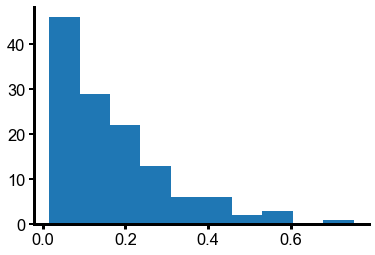

In [50]:
plt.hist(tc_mod[:,0].flatten())

In [ ]:
tc_mod.shape, dmodel.shape

In [ ]:
avg_fr.shape

In [51]:
dmodel = mse_add-mse_mult
dmodel = dmodel[:,:,(0,-1)]

for modeln in range(len(titles)):
    dmodel[(avg_fr[:,modeln]<thresh_fr) & (np.abs(tc_mod[:,modeln].squeeze())>.25)]=0
dmult_num = np.sum(dmodel_sig>0)/np.size(dmodel_sig[dmodel_sig!=0])
dadd_num = np.sum(dmodel_sig<0)/np.size(dmodel_sig[dmodel_sig!=0])

NameError: name 'dmodel_sig' is not defined

In [ ]:
save_dir

In [ ]:
mod_data = {'dmode':dmodel,'tc_mod':tc_mod}

np.savez(save_dir/'dmodels.npz', mod_data)

In [ ]:
np.unravel_index(np.argmax(dmodel),dmodel.shape)

In [ ]:
# dmodel = mse_add-mse_mult
# dmodel = dmodel[:,:,(0,-1)].flatten()
# dmodel = dmodel[np.abs(dmodel)>.002]
# dmult_num = np.sum(dmodel>0)/np.size(dmodel)
# dadd_num = np.sum(dmodel<0)/np.size(dmodel)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(dmodel_sig[dmodel_sig<0],bins=np.arange(-.1,0,.002),color='b')
ax.axvline(x=np.median(dmodel_sig[dmodel_sig<0]),color='b',linestyle='--')

ax.hist(dmodel_sig[dmodel_sig>0],bins=np.arange(.002,.1,.002),color='r')
ax.axvline(x=np.median(dmodel_sig[dmodel_sig>0]),color='r',linestyle='--')
ax.legend(['Add. Median','Mult.Median'])
ax.set_xlabel(r'$\Delta$MSE')
# fig.savefig(FigPath/'AddMultHist.png', facecolor='white', transparent=True)
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(0,dadd_num*100, color='b')
ax.bar(1,dmult_num*100, color='r')
# ax.scatter(np.zeros(len(dadd)),dadd,sz=3,)
ax.set_ylim(0,100)
ax.set_xticks([0,1])
ax.set_xticklabels(['Add.','Mult.'])
ax.set_ylabel('Proportion (%)')
plt.tight_layout()
# fig.savefig(FigPath/'AddMult_Propotion.png', facecolor='white', transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(dmodel[dmodel<0],bins=np.arange(-.1,-.001,.002),color='b')
ax.axvline(x=np.median(dmodel[dmodel<0]),color='b',linestyle='--')
ax.hist(dmodel[dmodel>0],bins=np.arange(.001,.1,.002),color='r')
ax.axvline(x=np.median(dmodel[dmodel>0]),color='r',linestyle='--')
ax.legend(['Add. Median','Mult.Median'])
ax.set_xlabel(r'$\Delta$MSE')
# fig.savefig(FigPath/'AddMultHist.png', facecolor='white', transparent=True)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(0,dadd_num*100, color='b')
ax.bar(1,dmult_num*100, color='r')
# ax.scatter(np.zeros(len(dadd)),dadd,sz=3,)
ax.set_ylim(0,100)
ax.set_xticks([0,1])
ax.set_xticklabels(['Add.','Mult.'])
ax.set_ylabel('Proportion (%)')
plt.tight_layout()
# fig.savefig(FigPath/'AddMult_Propotion.png', facecolor='white', transparent=True)

In [ ]:
crange

In [ ]:
celln = 25# np.argmax(mcc)
bin_length=40
n=1; axn=1
fig, axs = plt.subplots(1,1,figsize=(15,5))
crange = np.max(np.abs(msta_up[celln,axn]))
img = axs.imshow(msta_up[celln,axn],cmap='gray',vmin=-crange+.01,vmax=crange-.01)
axs.axis('off')
# axs.set_title('Lag: {}ms'.format(int(1000*lag_list[axn]*model_dt)))
axs.set_title('Free Moving STA')

cbar = add_colorbar(img,) # orientation='horizontal',location='bottom'
cbar.set_ticks([-crange+.01,crange-.01])
cbar.set_ticklabels(['Dark','Light'])
plt.tight_layout()
fig.savefig(FigPath/'Example_STA_{}.png'.format(stim_type), facecolor='white', transparent=True)

### Exmaple Tunign Curves

In [79]:
model_dt = .05
do_shuffle=False
do_norm = False
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),len(quartiles)-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),len(quartiles)-1))
for celln in range(test_nsp.shape[-1]):
    for i, modeln in enumerate(range(len(titles))):
        metric = move_test[:,modeln]
        nranges = np.round(np.quantile(metric,quartiles),decimals=1)
        stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
        bin_std,_,_ =binned_statistic(metric,test_nsp[:,celln],statistic='std',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)
        tuning_curves[celln,modeln] = stat_range
        tuning_stds[celln,modeln] = bin_std
        

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


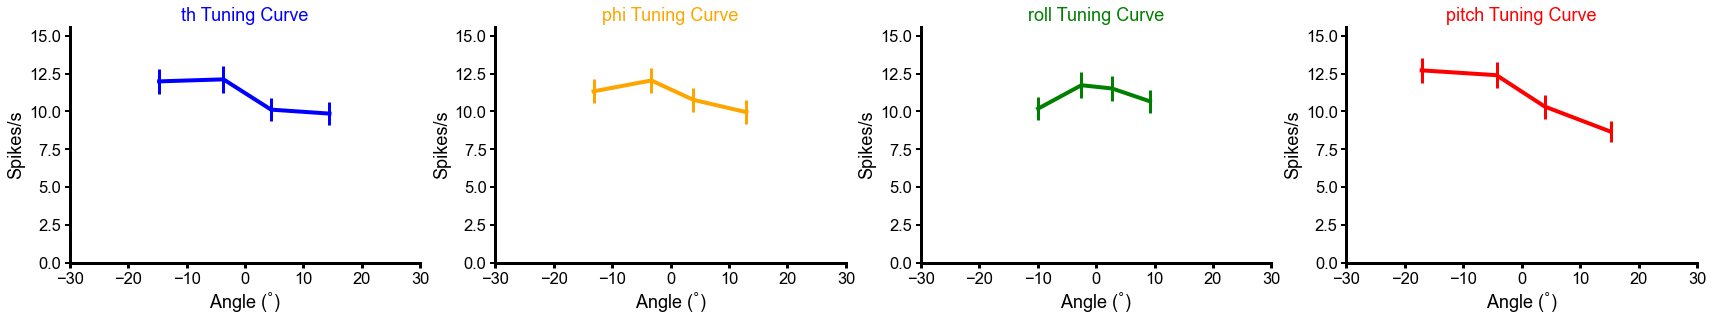

In [85]:
celln = 117

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
fig, axs = plt.subplots(1,4, figsize=(24,5))
# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles))):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
#     for m in range(len(nranges)-1):
#         axs[0,modeln].axvspan(nranges[m], nranges[m+1],alpha=0.8, color=colors[m],zorder=0)
    axs[modeln].errorbar(edge_mids,tuning_curves[celln,modeln]/model_dt, yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
#     axs[0,modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

#     axs[0,modeln].imshow(np.round(nranges,decimals=1)[None,:angn],aspect='auto', origin='lower',cmap=cmap,norm=norm,extent=(nranges[0],nranges[angn],0,top_yaxs),alpha=.8)
#     axs[0,modeln].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
    axs[modeln].set_xlim(-30,30)
    axs[modeln].set_xlabel('Angle ($ ^{\degree}$)')
    axs[modeln].set_ylabel('Spikes/s')
    axs[modeln].set_title('{} Tuning Curve'.format(titles[modeln]), color=clrs[modeln])
    
plt.tight_layout()
if do_shuffle:
    fig.savefig(FigPath/'TuningCurves_{}_Cell{}_shuff.pdf'.format(stim_type,celln), facecolor='white', transparent=True)
else:
    fig.savefig(FigPath/'TuningCurves_{}_Cell{}.pdf'.format(stim_type,celln), facecolor='white', transparent=True)

In [ ]:
# tc_mod = (tuning_curves-np.mean(tuning_curves,axis=(2))[:,:,np.newaxis])/(np.mean(tuning_curves,axis=(2))[:,:,np.newaxis])

tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.min(tuning_curves,axis=-1,keepdims=True)+np.max(tuning_curves,axis=-1,keepdims=True))

avg_fr = np.mean(tuning_curves,axis=-1).squeeze()

thresh_fr = 1
tuning_sig = tc_mod.copy()
tunig_sig = tuning_sig[avg_fr[:,modeln]<thresh_fr].squeeze()

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(25,5))
for modeln in np.arange(len(titles)):
    count,edges = np.histogram(tuning_sig[:,modeln], bins=np.arange(0,1.1,.05))
    edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    ax[modeln].bar(edges_mid, count/len(tuning_sig[:,modeln]),color=clrs[modeln],width=.05)
    ax[modeln].set_title('{}'.format(titles[modeln]), color=clrs[modeln])
    ax[modeln].set_xlabel('Modulation Index')
    ax[modeln].set_ylabel('Proportion')
    ax[modeln].set_xlim(0,1)
    ax[modeln].set_ylim(0,.4)
plt.tight_layout()
if do_shuffle:
    fig.savefig(FigPath/'TuningHists{}_shuff.png'.format(stim_type), facecolor='white', transparent=True)
else:
    fig.savefig(FigPath/'TuningHists{}.png'.format(stim_type), facecolor='white', transparent=True)

### Head Fixed

In [27]:
free_move = False
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 

data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT').expanduser() / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/070921/J553RT/').expanduser(), stim_type)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Encoding')

FigPath = check_path(FigPath, stim_type)
save_dir,data_dir,FigPath
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

(PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/hf1_wn'),
 PosixPath('/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/070921/J553RT/hf1_wn'),
 PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/hf1_wn'))

In [28]:
file_dict = {'cell': 0,
 'drop_slow_frames': True,
 'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
 'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
 'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
 'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
 'mp4': True,
 'name': '070921_J553RT_control_Rig2_'+stim_type,
 'probe_name': 'DB_P128-6',
 'save': data_dir.as_posix(),
 'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
 'stim_type': 'light',
 'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [29]:
model_dt = .05
do_shuffle=False
do_norm = False
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

Done Loading Aligned Data
TRAIN: 3853 TEST: 1652


<ipython-input-3-fc172eb0463b>:35: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [30]:
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'


[-1  0  1  2  3] [-50.   0.  50. 100. 150.]


In [31]:
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)

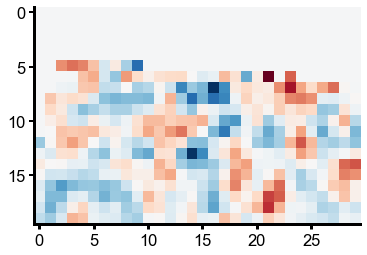

In [38]:
plt.imshow(msta[25,0,5:-5,5:-5],cmap='RdBu_r')

In [51]:
sf = 4
msta_up = np.zeros((msta.shape[0],msta.shape[1],sf*(msta.shape[-2]-10),sf*(msta.shape[-1]-10)))
for n in range(msta.shape[0]):
    for t in range(msta.shape[1]):
        msta_up[n,t] = cv2.resize(msta[n,t,5:-5,5:-5],(sf*(msta.shape[-1]-10),sf*(msta.shape[-2]-10)))


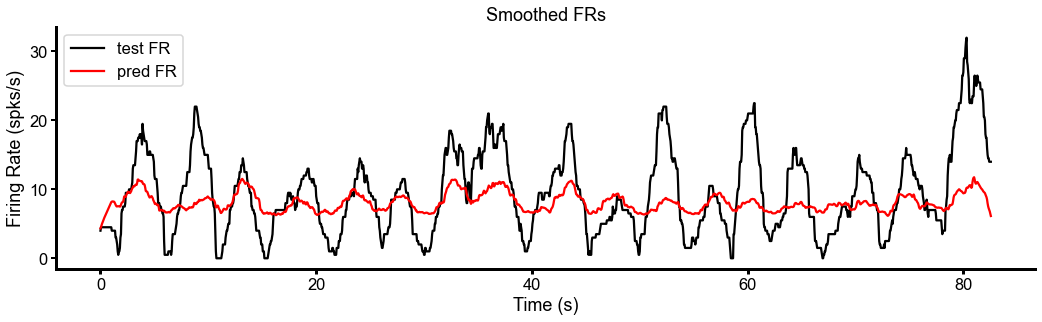

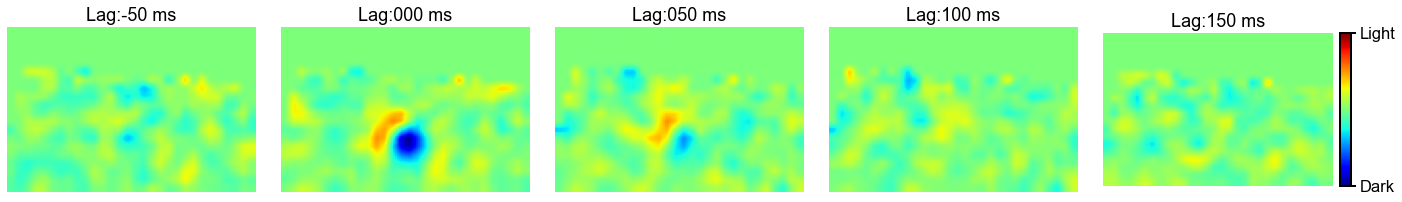

In [54]:
celln = 25# np.argmax(mcc)
bin_length=40
fig, axs = plt.subplots(1,figsize=(15,5))
predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
axs.plot(np.arange(len(msp_smooth))*model_dt,msp_smooth,'k',label='test FR')
axs.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs.set_xlabel('Time (s)')
axs.set_ylabel('Firing Rate (spks/s)')
axs.legend()
axs.set_title('Smoothed FRs')
plt.tight_layout()
# fig.savefig(FigPath/'Example_TestPred_{}_cell{}.pdf'.format(stim_type,celln), facecolor='white', transparent=True)
n=1; axn=4
fig, axs = plt.subplots(1,nt_glm_lag, figsize=((20,5))) 
crange = np.max(np.abs(msta[celln]))
for n in range(nt_glm_lag):
    img = axs[n].imshow(msta_up[celln,n],cmap='jet',vmin=-crange,vmax=crange)
    axs[n].axis('off')
    axs[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    axs[n].axis('off')
cbar = add_colorbar(img)
cbar.set_ticks([-crange,crange])
cbar.set_ticklabels(['Dark','Light'])
plt.tight_layout()
fig.savefig(FigPath/'Example_STA_{}_cell{}_jet.pdf'.format(stim_type,celln), facecolor='white', transparent=True)

## PyGLMNet

In [61]:
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
# x_train = train_vid.reshape(train_vid.shape[0],-1)
# x_train = np.hstack([np.roll(x_train, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
# x_test = test_vid.reshape(test_vid.shape[0],-1) 
# x_test = np.hstack([np.roll(x_test, nframes, axis=0) for nframes in lag_list])#


In [ ]:
np.arange(.0001,.002,.001)

In [70]:
from sklearn.model_selection import GridSearchCV
param_space = {
    'reg_lambda': np.array([.0001,.001,.002]),
}
glm = GLM(distr='poisson', score_metric='pseudo_R2', solver='cdfast', alpha=.5, tol=.0001, max_iter=300) # deviance
search = GridSearchCV(glm, param_space, cv=2, verbose=10)

import joblib
from ray.util.joblib import register_ray
register_ray()
with joblib.parallel_backend('ray'):
    search.fit(x_train, train_nsp[:,celln])
    

Fitting 2 folds for each of 3 candidates, totalling 6 fits
(pid=256853) [CV 1/2; 1/3] START reg_lambda=0.0001...........................................
(pid=256843) [CV 2/2; 1/3] START reg_lambda=0.0001...........................................
(pid=268873) [CV 1/2; 2/3] START reg_lambda=0.001............................................
(pid=256848) [CV 2/2; 2/3] START reg_lambda=0.001............................................
(pid=256842) [CV 1/2; 3/3] START reg_lambda=0.002............................................
(pid=256842) [CV 1/2; 3/3] END ..........................reg_lambda=0.002; total time=15.3min


(pid=256842) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
(pid=256842)   warnings.warn(
(pid=256848) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
(pid=256848)   warnings.warn(


(pid=256848) [CV 2/2; 2/3] END ..........................reg_lambda=0.001; total time=17.2min
(pid=268873) [CV 1/2; 2/3] END ..........................reg_lambda=0.001; total time=17.4min


(pid=268873) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
(pid=268873)   warnings.warn(
(pid=256853) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
(pid=256853)   warnings.warn(


(pid=256853) [CV 1/2; 1/3] END .........................reg_lambda=0.0001; total time=22.5min
(pid=256843) [CV 2/2; 1/3] END .........................reg_lambda=0.0001; total time=22.7min
(pid=256843) [CV 2/2; 3/3] START reg_lambda=0.002............................................


(pid=256843) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
(pid=256843)   warnings.warn(
(pid=256843) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
(pid=256843)   warnings.warn(


(pid=256843) [CV 2/2; 3/3] END ..........................reg_lambda=0.002; total time=14.6min


KeyboardInterrupt: 

In [80]:
search.estimator.beta0_

In [81]:
celln = 51
start = time.time()
glm = GLMCV(distr='poisson', score_metric='pseudo_R2', solver='cdfast', verbose=True, cv=2, alpha=.5,reg_lambda=[.0001,.001,.002],tol=.0001, max_iter=300)
glm.fit(x_train,train_nsp[:,celln])
print('GLM Time: ', time.time()-start)

Looping through the regularization path
Lambda: 0.0001
Lambda: 0.0001
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
Lambda: 0.0001
Lambda: 0.0001
Lambda: 0.0010
Lambda: 0.0010
Lambda: 0.0010
Lambda: 0.0010


KeyboardInterrupt: 

In [ ]:
glm.reg_lambda_opt_

In [ ]:
rf = glm.beta_.reshape(nt_glm_lag,train_vid.shape[1],train_vid.shape[2])

In [ ]:
yhat = glm.predict(x_test)


In [ ]:
plt.plot(test_nsp[:,celln])
plt.plot(yhat)

In [ ]:
plt.figure(figsize=(20,5))
plt.imshow(np.hstack(rf))

cleaning up fits, and how to quantify the fits, how to compare them to white noise RF's. take average then look at average shift. 

Getting add vs mult terms only for significant modulated neurons.

Compare decoding weights of visual vs motor, overlap with dot proudct



How to get an average across units for multiplictive?

# Vis+Movement SK learn

In [12]:

do_shuffle=False
bin_length=40
model_dt=.05
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 1)))
perm = perms[0]
##### Start GLM Parallel Processing #####
start = time.time()
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
# Reshape data (video) into (T*n)xN array
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis]))

celln = 117
##### Format data #####
nt_glm_lag = len(lag_list)
w_move = np.zeros(move_train.shape[-1])
xm_train = move_train[:,perm]
xm_test = move_test[:,perm]
x_train = np.concatenate((x_train,xm_train),axis=-1)
x_test = np.concatenate((x_test,xm_test),axis=-1)
# Shift spikes by -lag for GLM fits
sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)

lambdas = 2**np.arange(0,16)
nlam = len(lambdas)
# Initialze mse traces for regularization cross validation
error_train = np.zeros((nlam,1))
error_test = np.zeros((nlam,1))
pred_all =np.zeros((x_test.shape[0],nlam)) 
w_cv = np.zeros((x_train.shape[-1],nlam))
w_intercept = np.zeros((nlam,1))
# loop over regularization strength
for l in range(len(lambdas)):
    model = lm.PoissonRegressor(alpha=lambdas[l],max_iter=300)
    # calculate MAP estimate               
    model.fit(x_train,sps_train)
    w_cv[:,l] = model.coef_
    w_intercept[l] = model.intercept_
    pred_all[:,l] = model.predict(x_test)
    # calculate test and training rms error
    error_train[l] = mean_poisson_deviance(sps_train,model.predict(x_train)) #np.mean((sps_train - model.predict(x_train))**2)
    error_test[l] = mean_poisson_deviance(sps_test,pred_all[:,l]) # np.mean((sps_test - model.predict(x_test))**2)
# select best cross-validated lambda for RF
best_lambda = np.argmin(error_test)
w = w_cv[:,best_lambda]
intercept= w_intercept[best_lambda]
sta_all = np.reshape(w[:-xm_train.shape[-1]],(nt_glm_lag,)+nks)
w_move[perm] = w[-xm_train.shape[-1]:]
sp_pred = pred_all[:,best_lambda]

# predicted firing rate
# bin the firing rate to get smooth rate vs time
sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
# a few diagnostics
err = np.mean((sp_smooth-pred_smooth)**2)
cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
cc_all = cc[0,1]
r2_all = r2_score(sp_smooth,pred_smooth)
print('GLM: ', time.time()-start)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
[-1  0  1  2  3] [-50.   0.  50. 100. 150.]
GLM:  19.8111093044281


In [14]:
@ray.remote
def do_glm_fit_vismov_skl(train_nsp, test_nsp, x_train, x_test, move_train, move_test, perm, celln, lag_list, pbar:ActorHandle, bin_length=40, model_dt=.05):
    ##### Format data #####
    nt_glm_lag = len(lag_list)
    w_move = np.zeros(move_train.shape[-1])
    xm_train = move_train[:,perm]
    xm_test = move_test[:,perm]
    x_train = np.concatenate((x_train,xm_train),axis=-1)
    x_test = np.concatenate((x_test,xm_test),axis=-1)
    # Shift spikes by -lag for GLM fits
    sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
    sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)

    lambdas = 2**np.arange(0,16)
    nlam = len(lambdas)
    # Initialze mse traces for regularization cross validation
    error_train = np.zeros((nlam,1))
    error_test = np.zeros((nlam,1))
    pred_all =np.zeros((x_test.shape[0],nlam)) 
    w_cv = np.zeros((x_train.shape[-1],nlam))
    w_intercept = np.zeros((nlam,1))
    # loop over regularization strength
    for l in range(len(lambdas)):
        model = lm.PoissonRegressor(alpha=lambdas[l],max_iter=300)
        # calculate MAP estimate               
        model.fit(x_train,sps_train)
        w_cv[:,l] = model.coef_
        w_intercept[l] = model.intercept_
        pred_all[:,l] = model.predict(x_test)
        # calculate test and training rms error
        error_train[l] = mean_poisson_deviance(sps_train,model.predict(x_train)) #np.mean((sps_train - model.predict(x_train))**2)
        error_test[l] = mean_poisson_deviance(sps_test,pred_all[:,l]) # np.mean((sps_test - model.predict(x_test))**2)
    # select best cross-validated lambda for RF
    best_lambda = np.argmin(error_test)
    w = w_cv[:,best_lambda]
    intercept= w_intercept[best_lambda]
    sta_all = np.reshape(w[:-xm_train.shape[-1]],(nt_glm_lag,)+nks)
    w_move[perm] = w[-xm_train.shape[-1]:]
    sp_pred = pred_all[:,best_lambda]

    # predicted firing rate
    # bin the firing rate to get smooth rate vs time
    sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    # a few diagnostics
    err = np.mean((sp_smooth-pred_smooth)**2)
    cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
    cc_all = cc[0,1]
    r2_all = r2_score(sp_smooth,pred_smooth)
    pbar.update.remote(1)
    return cc_all, sta_all, sps_test, sp_pred, r2_all, w_move

In [15]:
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'


[-1  0  1  2  3] [-50.   0.  50. 100. 150.]


In [ ]:
for do_shuffle in [False,True]:
    # Load Data
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)

    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    ##### Start GLM Parallel Processing #####
    start = time.time()
    nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
    # Reshape data (video) into (T*n)xN array
    rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
    x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis]))

    # Put data into shared memory for parallization 
    num_ticks= (len(titles_all)*train_nsp.shape[-1])
    pb = ProgressBar(num_ticks)
    actor = pb.actor
    train_nsp_r = ray.put(train_nsp)
    test_nsp_r = ray.put(test_nsp)
    train_data_r = ray.put(x_train)
    test_data_r = ray.put(x_test)
    train_move_r = ray.put(move_train)
    test_move_r = ray.put(move_test)
    result_ids = []
    # Loop over parameters appending process ids
    for celln in range(train_nsp.shape[1]):
        for n in range(1,len(titles)+1):
            perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
            for ind in range(perms.shape[0]):
                result_ids.append(do_glm_fit_vismov_skl.remote(train_nsp_r, test_nsp_r, train_data_r, test_data_r, train_move_r, test_move_r, perms[ind], celln, lag_list, actor, model_dt=model_dt))

    print('N_proc:', len(result_ids))
    pb.print_until_done()
    results_p = ray.get(result_ids)
    print('GLM: ', time.time()-start)

    ##### Gather Data and Find Max CC Model #####
    cc_all = np.stack([results_p[i][0] for i in range(len(results_p))])
    sta_all = np.stack([results_p[i][1] for i in range(len(results_p))])
    sp_all = np.stack([results_p[i][2] for i in range(len(results_p))])
    pred_all = np.stack([results_p[i][3] for i in range(len(results_p))])
    r2_all = np.stack([results_p[i][4] for i in range(len(results_p))])
    wmove_all = np.stack([results_p[i][5] for i in range(len(results_p))])


    cc_all = cc_all.reshape((model_nsp.shape[1],len(titles_all),) + cc_all.shape[1:])
    sta_all = sta_all.reshape((model_nsp.shape[1],len(titles_all),) + sta_all.shape[1:])
    sp_all = sp_all.reshape((model_nsp.shape[1],len(titles_all),) + sp_all.shape[1:])
    pred_all = pred_all.reshape((model_nsp.shape[1],len(titles_all),) + pred_all.shape[1:])
    r2_all = r2_all.reshape((model_nsp.shape[1],len(titles_all),) + r2_all.shape[1:])
    wmove_all = wmove_all.reshape((model_nsp.shape[1],len(titles_all),) + wmove_all.shape[1:])

    m_cells, m_models,  = np.where(cc_all==np.max(cc_all,axis=(-1), keepdims=True))
    m_cells, m_cinds = np.unique(m_cells,return_index=True)
    m_models = m_models[m_cinds]

    mcc = cc_all[m_cells,m_models]
    msta = sta_all[m_cells,m_models]
    msp = sp_all[m_cells,m_models]
    mpred = pred_all[m_cells,m_models]
    mw_move = wmove_all[m_cells,m_models]
    mr2 = r2_all[m_cells,m_models]

    nt_glm_lag = len(lag_list)
    GLM_Data = {'cc_all': cc_all,
                'sta_all': sta_all,
                'sp_all': sp_all,
                'pred_all': pred_all,
                'r2_all':r2_all,
                'wmove_all':wmove_all,
                }

    if do_shuffle:
        ioh5.save(save_dir/'GLM_{}_Data_VisMov_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
    else:
        ioh5.save(save_dir/'GLM_{}_Data_VisMov_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)

    del train_nsp_r, test_nsp_r, train_data_r, test_data_r, result_ids, results_p, mcc, msta, msp, mpred, mr2,
    gc.collect()

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
N_proc: 1920


  0%|          | 0/1920 [00:00<?, ?it/s]

In [77]:
wmove_all = np.zeros((model_nsp.shape[1],len(titles_all),) + move_test.shape[1:])
j=0
for celln in range(train_nsp.shape[1]):
    i = 0
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            wmove_all[celln,i,perms[ind]] = results_p[j][5]
            j=j+1
            i=i+1

## Plotting

In [79]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMot_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


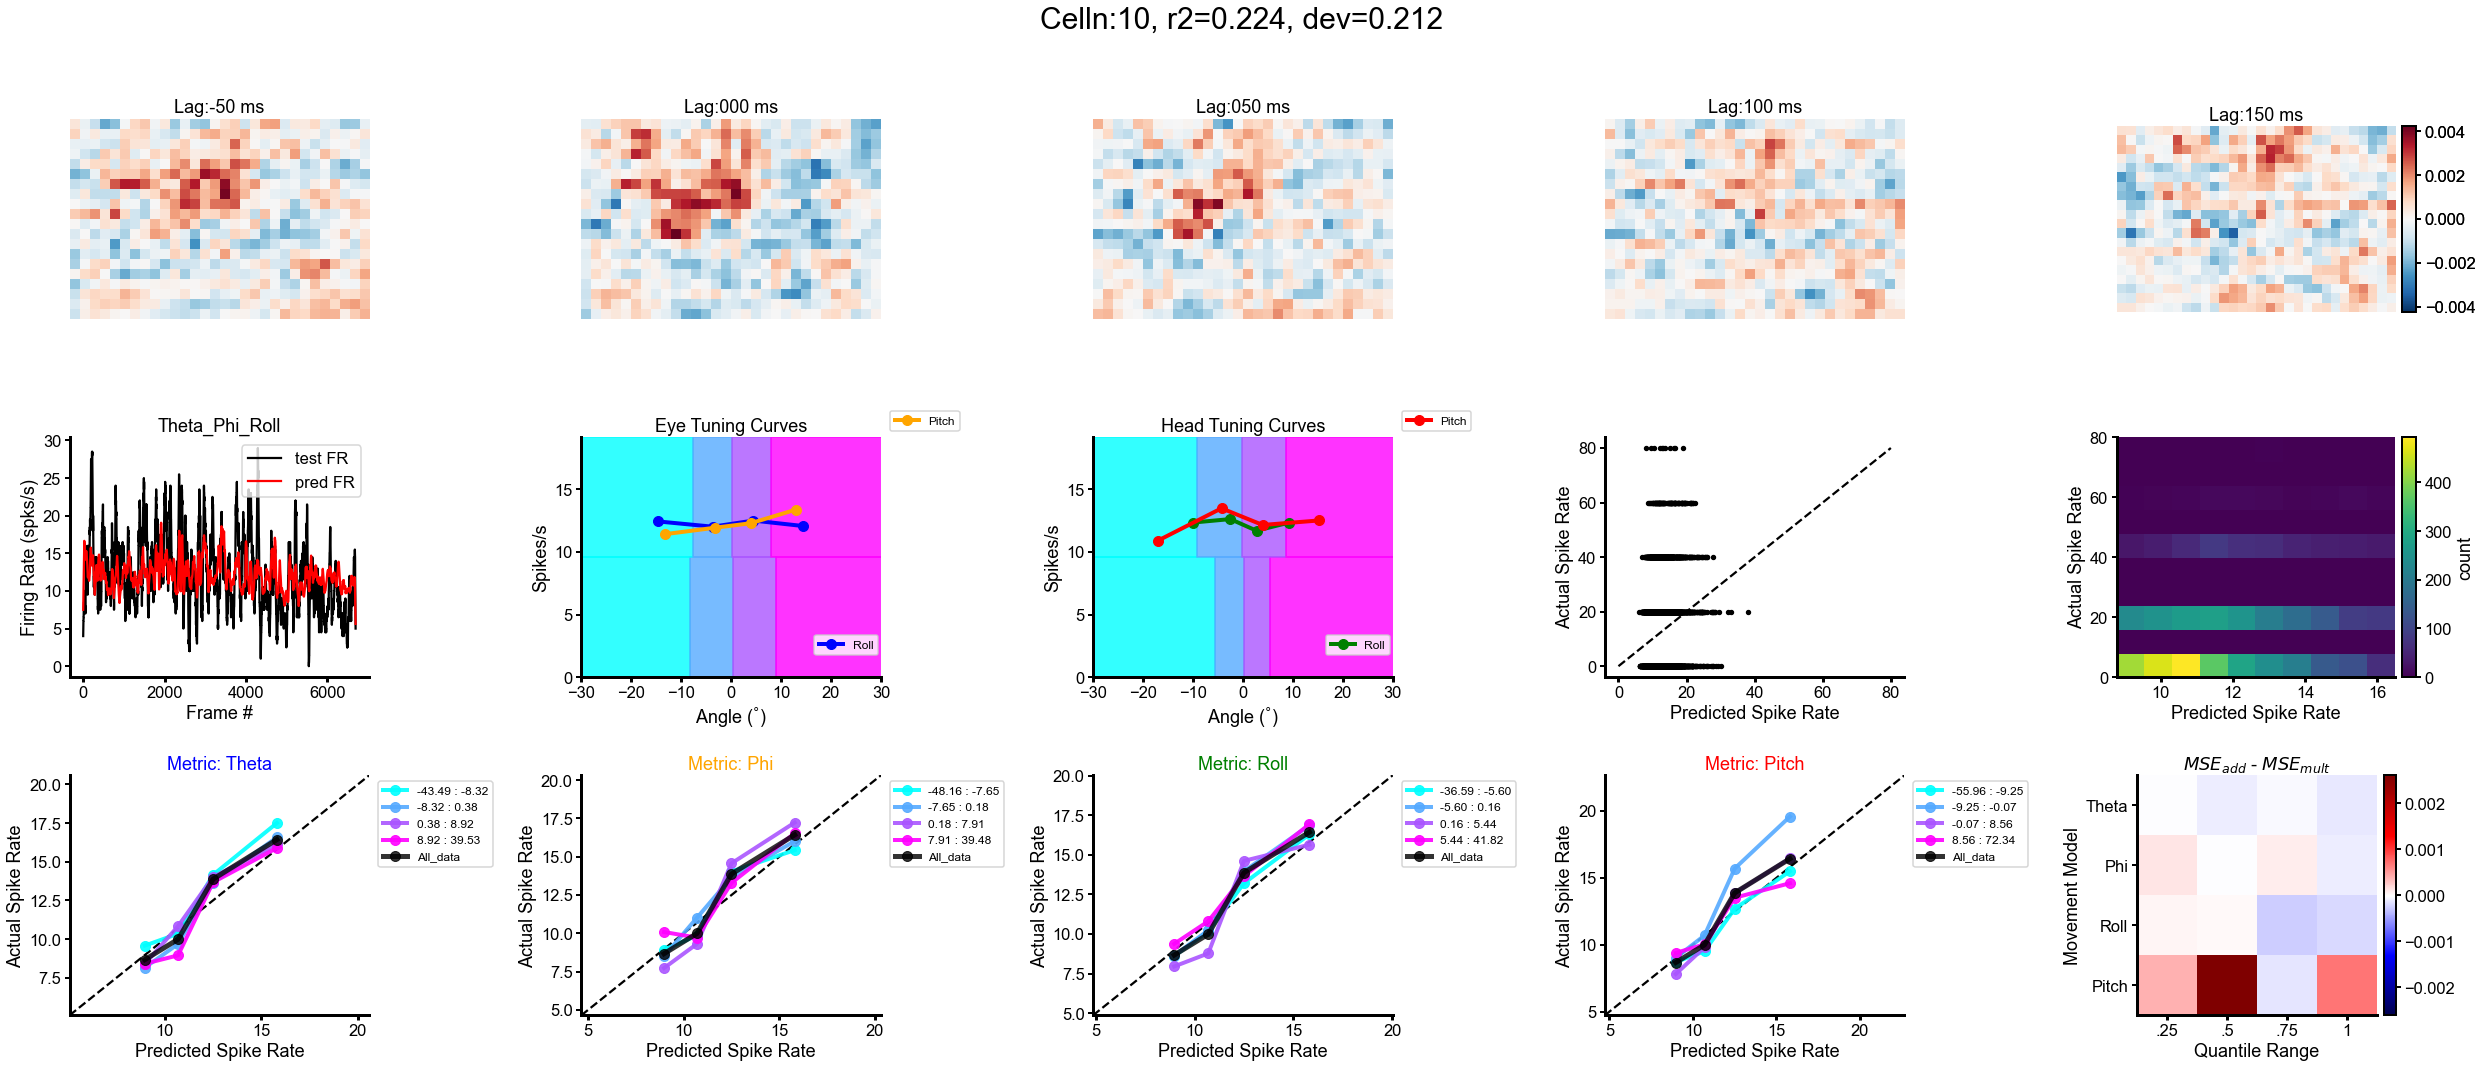

In [85]:
celln= 10 #np.argmax(mr2)
bin_length=40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# quartiles = np.arange(.1,1,.2)#[0,.25,.5,.75,1]
quartiles = np.arange(0,1.25,.25)
# lag=150 # in ms
# nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.arange(-1,4,dtype=int) #np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
msp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(msp_smooth,'k',label='test FR')
axs[1,0].plot(pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Frame #')
axs[1,0].set_ylabel('Firing Rate (spks/s)')
axs[1,0].legend()
axs[1,0].set_title('{}'.format(titles_all[m_models[celln]]))

crange = np.max(np.abs(msta[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(msta[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(mpred[celln]/model_dt,msp[celln]/model_dt,c='k',s=15)
axs[1,3].plot(np.linspace(msp_range[0],msp_range[1]),np.linspace(msp_range[0],msp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

hist,xedges,yedges,img =axs[1,4].hist2d(mpred[celln]/model_dt,msp[celln]/model_dt,range=np.vstack((pred_range,msp_range)))#pred_smooth,msp_smooth)
axs[1,4].set_xlabel('Predicted Spike Rate')
axs[1,4].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
cbar.set_label('count')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
    lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)

#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
#     axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}, dev={:.03f}'.format(celln,mcc[celln]**2,mr2[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

### Overview PDF

In [87]:
bin_length=40
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for model_dt in [.05]: #
    lag=150 # in ms
    nt_glm_lag = 5
#     minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
    lag_list = np.arange(-1,4,dtype=int) #np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
    nt_glm_lag = len(lag_list)
    if do_shuffle:
        GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisMot_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
        locals().update(GLM_Vis_shuff)
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMot_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
        locals().update(GLM_Vis)
    
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMot_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.max(tuning,axis=1)
        var_ranges[modeln] = var_range
        
    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_GLM_{}_dt{:03d}_T{:02d}_cellsummary_sig_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    else:
        pdf_name = FigPath/ 'VisMov_GLM_{}_dt{:03d}_T{:02d}_cellsummary_sig.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(msp.shape[0])):
            if mcc[celln]>.25:
                fig, axs = plt.subplots(3,5, figsize=((35,15))) 
                gs = axs[0,0].get_gridspec()
                gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
                for ax in axs[0,:]:
                    ax.remove()
                top_grid = np.zeros((nt_glm_lag),dtype=object)
                for ind in range(nt_glm_lag):
                    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

                predcell = mpred[celln]/model_dt
                nspcell = msp[celln]/model_dt
                msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
                pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
                # Set up predicted spike range between 1-99th percentile
                stat_bins = 5
                pred_range = np.quantile(predcell,[.1,.9])
                msp_range = np.quantile(nspcell,[.01,1])
                spike_percentiles = np.arange(0,1.25,.25)
                spike_percentiles[-1]=.99
                spk_percentile2 = np.arange(.125,1.125,.25)
                pred_rangelin = np.quantile(predcell,spike_percentiles)
                xbin_pts = np.quantile(predcell,spk_percentile2)
                stat_bins = len(pred_rangelin) #5


                axs[1,0].plot(msp_smooth,'k',label='test FR')
                axs[1,0].plot(pred_smooth,'r', label='pred FR')
                axs[1,0].set_xlabel('Frame #')
                axs[1,0].set_ylabel('Firing Rate (spks/s)')
                axs[1,0].legend()
                axs[1,0].set_title('{}'.format(titles_all[m_models[celln]]))

                crange = np.max(np.abs(msta[celln]))
                for n in range(nt_glm_lag):
                    img = top_grid[n].imshow(msta[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
                    top_grid[n].axis('off')
                    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
                    top_grid[n].axis('off')
                add_colorbar(img)

                # Eye Tuning Curve
                top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
                for i,modeln in enumerate(range(len(titles)-2)):
                    metric = move_test[:,modeln]
                    nranges = np.quantile(metric,quartiles)
                    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
                axs[1,1].set_xlim(-30,30)
                axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
                axs[1,1].set_ylabel('Spikes/s')
                axs[1,1].set_title('Eye Tuning Curves')
                lines = axs[1,1].get_lines()
                legend1 = axs[1,1].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,1].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
                axs[1,1].add_artist(legend1)

                # Head Tuning Curves
                top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
                for i, modeln in enumerate(range(2,len(titles))):
                    metric = move_test[:,modeln]
                #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                    for m in range(len(nranges)-1):
                        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

                axs[1,2].set_ylim(bottom=0,top=top_yaxs)
                axs[1,2].set_xlim(-30,30)
                axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
                axs[1,2].set_ylabel('Spikes/s')
                axs[1,2].set_title('Head Tuning Curves')
                lines = axs[1,2].get_lines()
                legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
                legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, 1), fontsize=12)
                axs[1,2].add_artist(legend1)

                # axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


                # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
                axs[1,3].scatter(mpred[celln]/model_dt,msp[celln]/model_dt,c='k',s=15)
                axs[1,3].plot(np.linspace(msp_range[0],msp_range[1]),np.linspace(msp_range[0],msp_range[1]),'k--',zorder=0)
                axs[1,3].set_xlabel('Predicted Spike Rate')
                axs[1,3].set_ylabel('Actual Spike Rate')
                cbar = add_colorbar(img)
                # cbar.set_label('count')

                hist,xedges,yedges,img =axs[1,4].hist2d(mpred[celln]/model_dt,msp[celln]/model_dt,range=np.vstack((pred_range,msp_range)))#pred_smooth,msp_smooth)
                axs[1,4].set_xlabel('Predicted Spike Rate')
                axs[1,4].set_ylabel('Actual Spike Rate')
                cbar = add_colorbar(img)
                cbar.set_label('count')


                mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
                alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

                traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
                edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
                # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
                for modeln in range(len(titles)):
                    metric = move_test[:,modeln]
                    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces_mean[celln,modeln]=stat_all
                    max_fr = np.max(stat_all)
                #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
                #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                    for n in range(len(nranges)-1):
                        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                        pred = predcell[ind]
                        sp = nspcell[ind]

                        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                        traces[celln,modeln,n]=stat_range
                        edges_all[celln,modeln,n]=edge_mids
                        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                        mse_add[celln, modeln, n] = res_add.fun
                        mse_mult[celln, modeln, n] = res_mult.fun
                        alpha_add[celln, modeln, n] = res_add.x
                        alpha_mult[celln, modeln, n] = res_mult.x

                        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                        axs[2,modeln].set_xlabel('Predicted Spike Rate')
                        axs[2,modeln].set_ylabel('Actual Spike Rate')

                    lim_max = np.max(traces[celln,modeln])+np.std(traces_mean[celln,modeln])
                    lim_min = np.min(traces[celln,modeln])-np.std(traces_mean[celln,modeln])
                    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

                    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
                #     axs[2,modeln].axis('equal')
                #     axs[2,modeln].set_xlim(left=0)
                    axs[2,modeln].set(xlim=lims, ylim=lims)

                #     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
                #     axs[2,modeln].set_ylim(bottom=0)

                dmodel = mse_add[celln]-mse_mult[celln]
                crange = np.max(np.abs(dmodel))
                im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
                axs[2,-1].set_yticks(np.arange(0,4))
                axs[2,-1].set_yticklabels(titles)
                axs[2,-1].set_ylabel('Movement Model')
                axs[2,-1].set_xticks(np.arange(0,4))
                axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
                axs[2,-1].set_xlabel('Quantile Range')
                axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
                cbar = add_colorbar(im)

                plt.suptitle('Celln:{}, r2={:.03f}, dev={:.03f}'.format(celln,mcc[celln]**2,mr2[celln]),y=1,fontsize=30)
                plt.tight_layout()


                # fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)
                pdf.savefig()
                plt.close()

    # fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


  0%|          | 0/128 [00:00<?, ?it/s]

### Shuffle Comparison

In [18]:
GLM_Vis_shuff.keys()

dict_keys(['cc_all', 'pred_all', 'r2_all', 'sp_all', 'sta_all', 'wmove_all'])

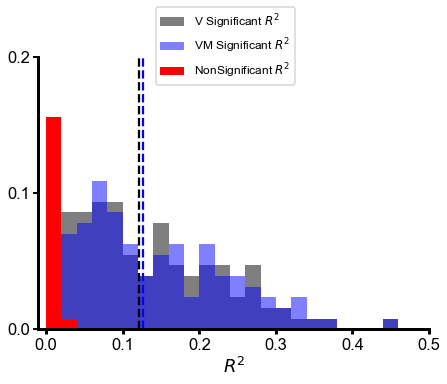

In [41]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisMov_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
m_cells, m_models,  = np.where(GLM_Vis_shuff['cc_all']==np.max(GLM_Vis_shuff['cc_all'],axis=(-1), keepdims=True))
m_cells, m_cinds = np.unique(m_cells,return_index=True)
m_models_shuff = m_models[m_cinds]
mcc_shuff = GLM_Vis_shuff['cc_all'][m_cells,m_models]
msta_shuff = GLM_Vis_shuff['sta_all'][m_cells,m_models]
msp_shuff = GLM_Vis_shuff['sp_all'][m_cells,m_models]
mpred_shuff = GLM_Vis_shuff['pred_all'][m_cells,m_models]
mw_move_shuff = GLM_Vis_shuff['wmove_all'][m_cells,m_models]
mr2_shuff = GLM_Vis_shuff['r2_all'][m_cells,m_models]


GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
m_cells, m_models,  = np.where(GLM_Vis['cc_all']==np.max(GLM_Vis['cc_all'],axis=(-1), keepdims=True))
m_cells, m_cinds = np.unique(m_cells,return_index=True)
m_models = m_models[m_cinds]
mcc_vm = GLM_Vis['cc_all'][m_cells,m_models]
msta_vm = GLM_Vis['sta_all'][m_cells,m_models]
msp_vm = GLM_Vis['sp_all'][m_cells,m_models]
mpred_vm= GLM_Vis['pred_all'][m_cells,m_models]
mw_move_vm = GLM_Vis['wmove_all'][m_cells,m_models]
mr2_vm = GLM_Vis['r2_all'][m_cells,m_models]

GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
max_shuff = np.max(mcc_shuff**2)
mr2 = (GLM_Vis['mcc'])**2
fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = mr2[mr2>max_shuff]
non_sig = mr2[mr2<max_shuff]

count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,.02))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='V Significant $R^2$')
ax.axvline(x=np.mean(mr2),color='k',ls='--')

# ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.02,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))


max_shuff = np.max(mcc_shuff**2)
mr2_vm = (mcc_vm)**2
# fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = mr2_vm[mr2_vm>max_shuff]
non_sig_vm = mr2_vm[mr2_vm<max_shuff]

count,edges = np.histogram(mr2_vm,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram(non_sig_vm,bins=np.arange(0,1,.02))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(mcc),color='b',width=.02,alpha=.5, label='VM Significant $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(mcc),color='r',width=.02,alpha=1, label='NonSignificant $R^2$')
ax.axvline(x=np.mean(mr2_vm),color='b',ls='--')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))
fig.savefig(FigPath/'R2_comparison_VisMov_notsmooth_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

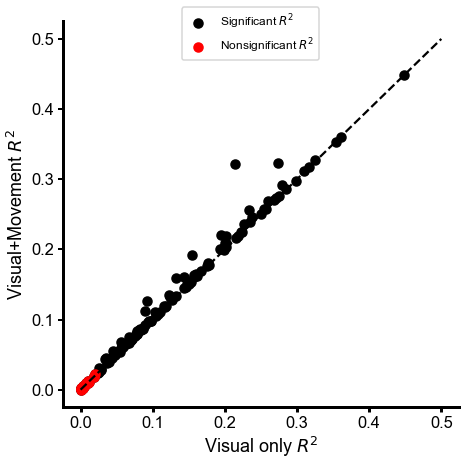

In [51]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(mr2,mr2_vm,c='k',label='Significant $R^2$')
ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsignificant $R^2$')
plt.plot(np.arange(0,np.max(mr2_vm)+.1,.1),np.arange(0,np.max(mr2_vm)+.1,.1),'k--')
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('Visual+Movement $R^2$')
plt.tight_layout()
fig.savefig(FigPath/'R2_comparison_VisMov_scatter_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

NameError: name 'inset_axes' is not defined

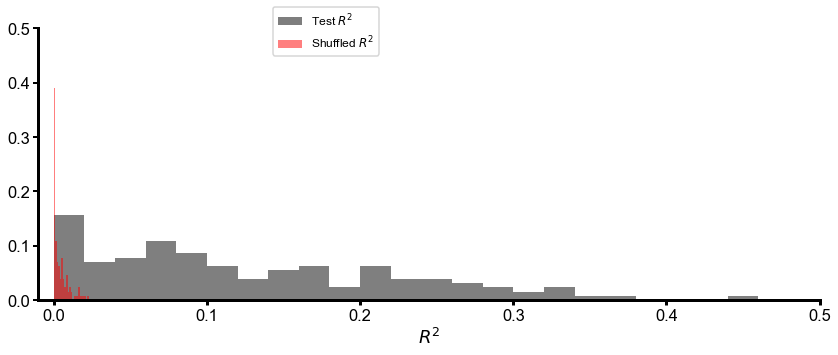

In [24]:
fig,ax = plt.subplots(1,1,figsize=(14,5))

# sig = mr2[mr2>max_shuff]
count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram((mcc_shuff)**2,bins=np.arange(0,1,.001))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(mcc),color='k',width=.02,alpha=.5, label='Test $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(mcc),color='r',width=.001,alpha=.5, label='Shuffled $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.5)
ax.legend(fontsize=12,loc=(.3,.9))

# non_sig = mr2[mr2<max_shuff]
count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram((mcc_shuff)**2,bins=np.arange(0,1,.001))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])

axins = inset_axes(ax, width=5, height=2)
axins.bar(edges_mid, count/len(mcc),color='k',width=.02,alpha=.5, label='Test $R^2$')
axins.bar(edges_mid_shuff, count_shuff/len(mcc),color='r',width=.001,alpha=.5, label='Shuffled $R^2$')
axins.set_xlabel('$R^2$')
axins.set_yticks(np.arange(0,1,.1))
axins.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
axins.set_xlim(-.001,.04)
axins.set_ylim(0,.5)
# axins.legend(fontsize=12)

fig.savefig(FigPath/'R2_comparison_VisMov_notsmooth_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

# Model Comparisons

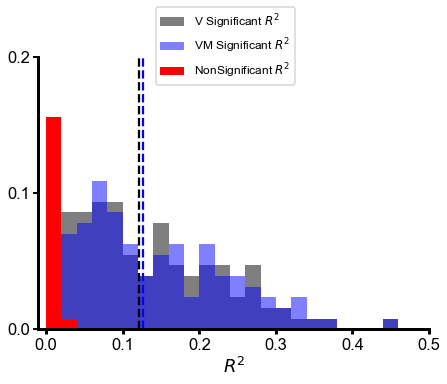

In [42]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisMov_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
m_cells, m_models,  = np.where(GLM_Vis_shuff['cc_all']==np.max(GLM_Vis_shuff['cc_all'],axis=(-1), keepdims=True))
m_cells, m_cinds = np.unique(m_cells,return_index=True)
m_models_shuff = m_models[m_cinds]
mcc_shuff = GLM_Vis_shuff['cc_all'][m_cells,m_models]
msta_shuff = GLM_Vis_shuff['sta_all'][m_cells,m_models]
msp_shuff = GLM_Vis_shuff['sp_all'][m_cells,m_models]
mpred_shuff = GLM_Vis_shuff['pred_all'][m_cells,m_models]
mw_move_shuff = GLM_Vis_shuff['wmove_all'][m_cells,m_models]
mr2_shuff = GLM_Vis_shuff['r2_all'][m_cells,m_models]


GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
m_cells, m_models,  = np.where(GLM_Vis['cc_all']==np.max(GLM_Vis['cc_all'],axis=(-1), keepdims=True))
m_cells, m_cinds = np.unique(m_cells,return_index=True)
m_models = m_models[m_cinds]
mcc_vm = GLM_Vis['cc_all'][m_cells,m_models]
msta_vm = GLM_Vis['sta_all'][m_cells,m_models]
msp_vm = GLM_Vis['sp_all'][m_cells,m_models]
mpred_vm= GLM_Vis['pred_all'][m_cells,m_models]
mw_move_vm = GLM_Vis['wmove_all'][m_cells,m_models]
mr2_vm = GLM_Vis['r2_all'][m_cells,m_models]

GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
max_shuff = np.max(mcc_shuff**2)
mr2 = (GLM_Vis['mcc'])**2
fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = mr2[mr2>max_shuff]
non_sig = mr2[mr2<max_shuff]

count,edges = np.histogram(mr2,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,.02))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_Vis['mcc']),color='k',width=.02,alpha=.5, label='V Significant $R^2$')
ax.axvline(x=np.mean(mr2),color='k',ls='--')

# ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['mcc']),color='r',width=.02,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))


max_shuff = np.max(mcc_shuff**2)
mr2_vm = (mcc_vm)**2
# fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = mr2_vm[mr2_vm>max_shuff]
non_sig_vm = mr2_vm[mr2_vm<max_shuff]

count,edges = np.histogram(mr2_vm,bins=np.arange(0,1,.02))
count_shuff,edges_shuff = np.histogram(non_sig_vm,bins=np.arange(0,1,.02))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(mcc),color='b',width=.02,alpha=.5, label='VM Significant $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(mcc),color='r',width=.02,alpha=1, label='NonSignificant $R^2$')
ax.axvline(x=np.mean(mr2_vm),color='b',ls='--')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))
# fig.savefig(FigPath/'R2_comparison_VisMov_notsmooth_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

In [49]:
GLM_mot['cc_all'].shape, m_cells.shape, m_models.shape,(GLM_mot['cc_all']==np.max(GLM_mot['cc_all'],axis=(-1),keepdims=True))[76]
# m_cells, m_models, = np.where(GLM_mot['cc_all']==np.max(GLM_mot['cc_all'],axis=(-1), keepdims=True))
# m_cells,np.argmax((np.diff(m_cells)))
np.nanmax(GLM_mot['cc_all'],axis=(-1),keepdims=True)[76]

array([0.03619349])

In [24]:

# GLM_mot_shuff = ioh5.load(save_dir/'GLM_{}_Data_MotOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
GLM_mot = ioh5.load(save_dir/'GLM_{}_Data_MotOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))

m_cells, m_models, = np.where(GLM_mot['cc_all']==np.nanmax(GLM_mot['cc_all'],axis=(-1), keepdims=True))
# m_cells, m_cinds = np.unique(m_cells,return_index=True)
# m_models = m_models[m_cinds]
mcc_m = GLM_mot['cc_all'][m_cells,m_models]
msp_m = GLM_mot['sp_raw'][m_cells,m_models]
mpred_m = GLM_mot['pred_raw'][m_cells,m_models]
mw_move_m = GLM_mot['w_move_all'][m_cells,m_models]
mr2_m = GLM_mot['r2_all'][m_cells,m_models]
mr2_m = mcc_m**2

In [28]:
mcc_m.shape

(128,)

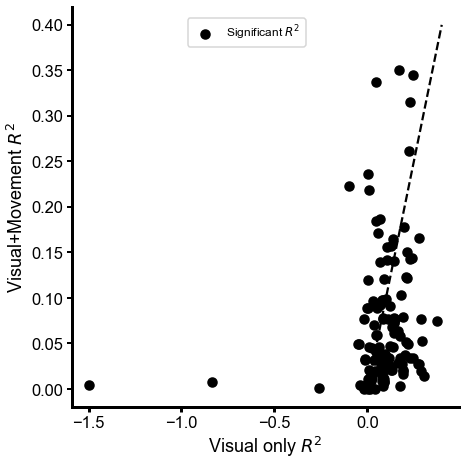

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(mr2,mr2_m,c='k',label='Significant $R^2$')
# ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsignificant $R^2$')
plt.plot(np.arange(0,np.max(mr2)+.1,.1),np.arange(0,np.max(mr2)+.1,.1),'k--')
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('Visual+Movement $R^2$')
plt.tight_layout()
# fig.savefig(FigPath/'R2_comparison_VisMov_scatter_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

In [52]:
mr2.shape,mr2_m.shape

((128,), (128,))

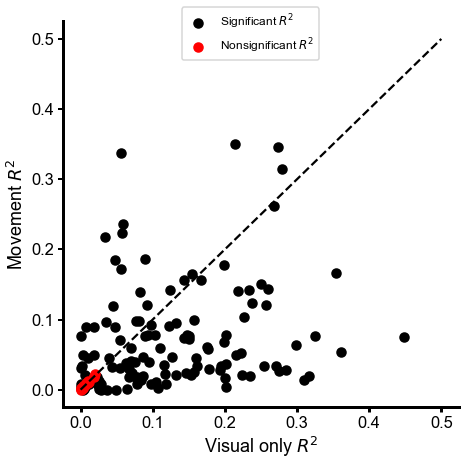

In [58]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(mr2,mr2_m,c='k',label='Significant $R^2$')
ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsignificant $R^2$')
plt.plot(np.arange(0,np.max(mr2_vm)+.1,.1),np.arange(0,np.max(mr2_vm)+.1,.1),'k--')
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('Movement $R^2$')
plt.tight_layout()
fig.savefig(FigPath/'R2_comparison_Mov_scatter_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000), nt_glm_lag), facecolor='white', transparent=True)

In [56]:
mr2_m[125],mr2[125]

(0.22340927163834884, 0.05694389036102759)

In [53]:
np.argmax(mr2_vm-mr2)

126

# GLM Movement Only

In [9]:
model_type = 'poissonregressor'
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 4)))[0]

move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis])) #, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# for n in range(1,len(titles)+1):
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 1)))
#     for ind in range(perms.shape[0]):
#         for celln in range(76,77):
#     print(celln)
celln=76
##### Format data #####
w_move = np.zeros(move_train.shape[1])
# Shift spikes by -lag for GLM fits
sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)

# Reshape data (video) into (T*n)xN array
x_train = move_train[:,perms[ind]]
x_test = move_test[:,perms[ind]]

if model_type == 'elasticnetcv':
    model = lm.ElasticNetCV(l1_ratio=[.05, .01, .5, .7]) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
    model.fit(x_train,sps_train)
    w_move[perms] = model.coef_
    sp_pred = model.predict(x_test)
elif model_type == 'ridgecv':
    lambdas = 1024 * (2**np.arange(0,16))
    model = lm.RidgeCV(alphas=lambdas)
    model.fit(x_train,sps_train)
    w_move[perms] = model.coef_
    sp_pred = model.predict(x_test)
else:
    model = lm.PoissonRegressor(alpha=0,max_iter=300)
    # calculate MAP estimate               
    model.fit(x_train,sps_train)
    intercept=  model.intercept_
    w_move[perms[ind]] = model.coef_
    sp_pred = model.predict(x_test)

# bin the firing rate to get smooth rate vs time
sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
# a few diagnostics
err = np.mean((sp_smooth-pred_smooth)**2)
cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
cc_all = cc[0,1]
print(sp_pred,sps_test)
r2_all = r2_score(sp_smooth[bin_length:-bin_length],pred_smooth[bin_length:-bin_length])
# pbar.update.remote(1)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
[0.00198362 0.00198362 0.00198362 ... 0.00198362 0.00198362 0.00198362] [0. 0. 0. ... 0. 0. 0.]


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [125]:
model.fit(x_train,sps_train)

PoissonRegressor(alpha=0, max_iter=300)

In [135]:
sp_pred = model.predict(x_test)

In [15]:
model.coef_

array([0.])

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([[ 1., nan],
       [nan, nan]])

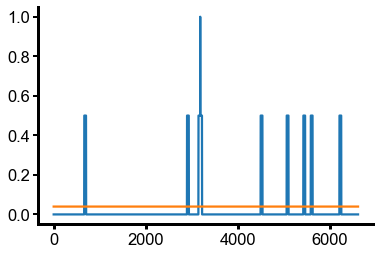

In [14]:
plt.plot(sp_smooth[bin_length:-bin_length])
plt.plot(pred_smooth[bin_length:-bin_length])
cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
cc

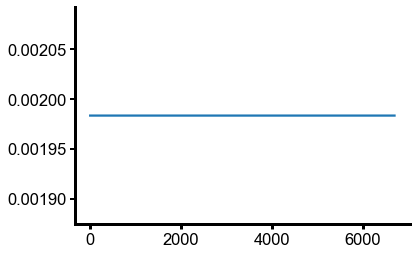

In [136]:
plt.plot(sp_pred)

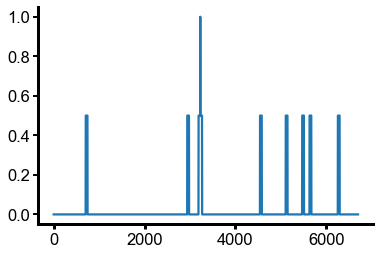

In [134]:
plt.plot(sp_smooth)

In [16]:
@ray.remote
def do_glm_fit_mot_skl(train_nsp, test_nsp, move_train, move_test, celln, perms, model_type, pbar:ActorHandle, bin_length=40, model_dt=.05):
    
    ##### Format data #####
    w_move = np.zeros(move_train.shape[1])
    # Shift spikes by -lag for GLM fits
    sps_train = train_nsp[:,celln] # np.roll(train_nsp[:,celln],-lag)
    sps_test = test_nsp[:,celln] # np.roll(test_nsp[:,celln],-lag)
    
    # Reshape data (video) into (T*n)xN array
    x_train = move_train[:,perms]
    x_test = move_test[:,perms]
    
    if model_type == 'elasticnetcv':
        model = lm.ElasticNetCV(l1_ratio=[.05, .01, .5, .7]) # lm.RidgeCV(alphas=np.arange(100,10000,1000))) #  #MultiOutputRegressor(lm.Ridge(),n_jobs=-1)) 
        model.fit(x_train,sps_train)
        w_move[perms] = model.coef_
        sp_pred = model.predict(x_test)
    elif model_type == 'ridgecv':
        lambdas = 1024 * (2**np.arange(0,16))
        model = lm.RidgeCV(alphas=lambdas)
        model.fit(x_train,sps_train)
        w_move[perms] = model.coef_
        sp_pred = model.predict(x_test)
    else:
        model = lm.PoissonRegressor(alpha=0,max_iter=300)
        # calculate MAP estimate               
        model.fit(x_train,sps_train)
        intercept=  model.intercept_
        w_move[perms] = model.coef_
        sp_pred = model.predict(x_test)

    # bin the firing rate to get smooth rate vs time
    sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    # a few diagnostics
    err = np.mean((sp_smooth-pred_smooth)**2)
    cc = np.corrcoef(sp_smooth[bin_length:-bin_length], pred_smooth[bin_length:-bin_length])
    if cc[0,1]==np.nan:
        cc_all = 0
    else:
        cc_all = cc[0,1]
    r2_all = r2_score(sp_smooth[bin_length:-bin_length],pred_smooth[bin_length:-bin_length])
    pbar.update.remote(1)
    return cc_all, w_move, sps_test, sp_pred, r2_all

In [18]:
start = time.time()
model_type = 'poissonregressor'
nt_glm_lag=5
# Load Data
for do_shuffle in [False,True]:
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)

    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)

    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis])) #, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    # move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_dgaze_p[:,np.newaxis],train_dgaze_n[:,np.newaxis]))# train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))


    # Put data into shared memory for parallization 
    num_ticks= (len(titles_all)*train_nsp.shape[-1])
    pb = ProgressBar(num_ticks)
    actor = pb.actor
    train_nsp_r = ray.put(train_nsp)
    test_nsp_r = ray.put(test_nsp)
    # train_data_r = ray.put(train_vid)
    # test_data_r = ray.put(test_vid)
    move_train_r = ray.put(move_train)
    move_test_r = ray.put(move_test)
    result_ids = []
    # Loop over parameters appending process ids
    for celln in range(train_nsp.shape[1]):
        for n in range(1,len(titles)+1):
            perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
            for ind in range(perms.shape[0]):
                result_ids.append(do_glm_fit_mot_skl.remote(train_nsp_r, test_nsp_r, move_train_r, move_test_r, celln, perms[ind], model_type, actor, model_dt=model_dt))

    print('N_proc:', len(result_ids))
    pb.print_until_done()
    results_p = ray.get(result_ids)
    print('GLM Time: ', time.time()-start)

    ##### Gather Data and Find Max CC Model #####
    cc_all = np.stack([results_p[i][0] for i in range(len(results_p))])
    w_move_all = np.stack([results_p[i][1] for i in range(len(results_p))])
    sp_raw = np.stack([results_p[i][2] for i in range(len(results_p))])
    pred_raw = np.stack([results_p[i][3] for i in range(len(results_p))])
    r2_all =  np.stack([results_p[i][4] for i in range(len(results_p))])

    cc_all = cc_all.reshape((model_nsp.shape[1],len(titles_all),) + cc_all.shape[1:])
    w_move_all = w_move_all.reshape((model_nsp.shape[1],len(titles_all),) + w_move_all.shape[1:])
    sp_raw = sp_raw.reshape((model_nsp.shape[1],len(titles_all),) + sp_raw.shape[1:])
    pred_raw = pred_raw.reshape((model_nsp.shape[1],len(titles_all),) + pred_raw.shape[1:])
    r2_all = r2_all.reshape((model_nsp.shape[1],len(titles_all),) + r2_all.shape[1:])

    m_cells, m_models,  = np.where(cc_all==np.max(cc_all,axis=(-1), keepdims=True))
    m_cells, m_cinds = np.unique(m_cells,return_index=True)
    m_models = m_models[m_cinds]
    mcc = cc_all[m_cells,m_models]
    msp = sp_raw[m_cells,m_models]
    mpred = pred_raw[m_cells,m_models]
    mw_move = w_move_all[m_cells,m_models]
    mr2 = r2_all[m_cells,m_models]

    GLM_Data = {'cc_all': cc_all,
                'sp_raw': sp_raw,
                'pred_raw': pred_raw,
                'w_move_all': w_move_all,
                'r2_all': r2_all,}

    if do_shuffle:
        ioh5.save(save_dir/'GLM_{}_Data_MotOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
    else:
        ioh5.save(save_dir/'GLM_{}_Data_MotOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)

    del train_nsp_r, test_nsp_r, move_train_r, move_test_r, result_ids, results_p, mcc, msp, mpred, mr2,
    gc.collect()

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


(pid=256835) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(pid=256835)   c /= stddev[:, None]
(pid=256835) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(pid=256835)   c /= stddev[None, :]
(pid=256875) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(pid=256875)   c /= stddev[:, None]
(pid=256875) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(pid=256875)   c /= stddev[None, :]
(pid=256876) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(pid=256876)   c /= stddev

N_proc: 1920


  0%|          | 0/1920 [00:00<?, ?it/s]

GLM Time:  3.0922462940216064
Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


(pid=256883) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(pid=256883)   c /= stddev[:, None]
(pid=256883) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(pid=256883)   c /= stddev[None, :]


N_proc: 1920


  0%|          | 0/1920 [00:00<?, ?it/s]

(pid=256879) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(pid=256879)   c /= stddev[:, None]
(pid=256879) /home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(pid=256879)   c /= stddev[None, :]


GLM Time:  7.036675691604614


## Motor only Plotting

In [19]:
def f_add(alpha,stat_range,stat_all):
    return np.mean((stat_range - stat_all+alpha)**2)

def f_mult(alpha,stat_range,stat_all):
    return np.mean((stat_range - stat_all*alpha)**2)

In [20]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=False)
locals().update(data)
##### Explore Neurons #####
colors = plt.cm.winter(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)

move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis])) #, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
# move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_dgaze_p[:,np.newaxis],train_dgaze_n[:,np.newaxis]))# train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=.1)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


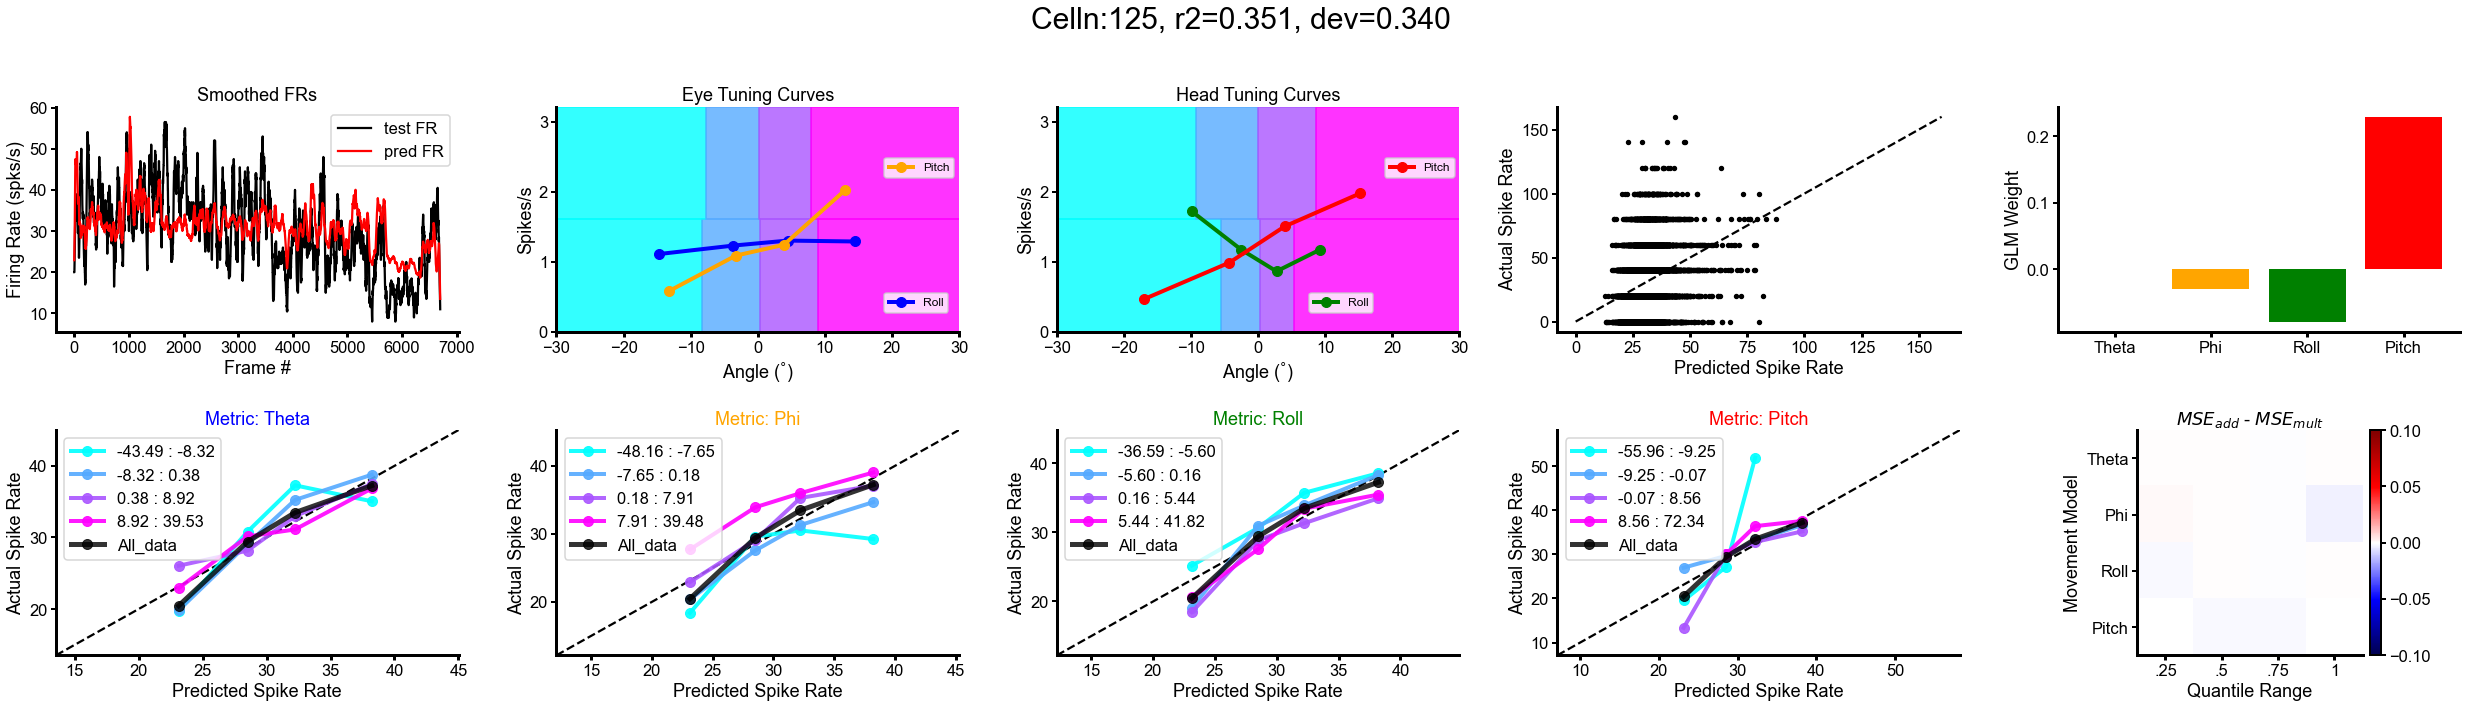

In [39]:
celln= 125 #np.argmax(mr2)
bin_length=40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# quartiles = np.arange(.1,1,.2)#[0,.25,.5,.75,1]
quartiles = np.arange(0,1.25,.25)
# lag=150 # in ms
# nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.arange(-1,4,dtype=int) #np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)

fig, axs = plt.subplots(2,5, figsize=((35,10))) #np.floor(7.5*len(model_nsp)).astype(int)

predcell = mpred[celln]/model_dt
nspcell = msp[celln]/model_dt
msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
msp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[0,0].plot(msp_smooth,'k',label='test FR')
axs[0,0].plot(pred_smooth,'r', label='pred FR')
axs[0,0].set_xlabel('Frame #')
axs[0,0].set_ylabel('Firing Rate (spks/s)')
axs[0,0].legend()
axs[0,0].set_title('Smoothed FRs')

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[0,1].set_xlim(-30,30)
axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,1].set_ylabel('Spikes/s')
axs[0,1].set_title('Eye Tuning Curves')
lines = axs[0,1].get_lines()
legend1 = axs[0,1].legend([lines[0]],[titles[2]],bbox_to_anchor=(.8, .2), fontsize=12)
legend2 = axs[0,1].legend([lines[1]],[titles[3]],bbox_to_anchor=(.8, .8), fontsize=12)
axs[0,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,2].set_ylim(bottom=0,top=top_yaxs)
axs[0,2].set_xlim(-30,30)
axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,2].set_ylabel('Spikes/s')
axs[0,2].set_title('Head Tuning Curves')
lines = axs[0,2].get_lines()
legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(.8, .2), fontsize=12)
legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(.8, .8), fontsize=12)
axs[0,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[0,3].scatter(mpred[celln]/model_dt,msp[celln]/model_dt,c='k',s=15)
axs[0,3].plot(np.linspace(msp_range[0],msp_range[1]),np.linspace(msp_range[0],msp_range[1]),'k--',zorder=0)
axs[0,3].set_xlabel('Predicted Spike Rate')
axs[0,3].set_ylabel('Actual Spike Rate')
# cbar.set_label('count')

for modeln in range(len(titles)):
    axs[0,4].bar(modeln, mw_move[celln,modeln], color=clrs[modeln])
    axs[0,4].set_xticks(np.arange(0,len(titles)))
    axs[0,4].set_xticklabels(titles)
    axs[0,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[1,modeln].set_xlabel('Predicted Spike Rate')
        axs[1,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.nanmax(traces[celln,modeln])+np.nanstd(traces_mean[celln,modeln])
    lim_min = np.nanmin(traces[celln,modeln])-np.nanstd(traces_mean[celln,modeln])
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[1,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)

    axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[1,modeln].legend()#bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[1,modeln].set(xlim=lims, ylim=lims)

#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
#     axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[1,-1].set_yticks(np.arange(0,4))
axs[1,-1].set_yticklabels(titles)
axs[1,-1].set_ylabel('Movement Model')
axs[1,-1].set_xticks(np.arange(0,4))
axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
axs[1,-1].set_xlabel('Quantile Range')
axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}, dev={:.03f}'.format(celln,mcc[celln]**2,mr2[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
with PdfPages(FigPath/ 'GLM_MotOnly_{}_dt{:03d}_T{:02d}_cellsummary_sig.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)) as pdf:
    for celln in tqdm(range(msp.shape[0])):
        if mcc[celln]>.3:
            fig, axs = plt.subplots(2,5, figsize=((25,10))) #np.floor(7.5*len(model_nsp)).astype(int)
            predcell = mpred[celln]/model_dt
            nspcell = msp[celln]/model_dt
            msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            axs[0,0].plot(msp_smooth,'k',label='test FR')
            axs[0,0].plot(pred_smooth,'r', label='pred FR')
            axs[0,0].set_xlabel('Frame #')
            axs[0,0].set_ylabel('Firing Rate (spks/s)')
            axs[0,0].legend()
            axs[0,0].set_title('Smoothed FRs')



            # Eye Tuning Curve
            for modeln in range(len(titles)-2):
                axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
            axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
            axs[0,1].set_xlim(-50,50)
            axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,1].set_ylabel('Spikes/s')
            axs[0,1].set_title('Eye Tuning Curves')
            axs[0,1].legend(bbox_to_anchor=(1.01, 1), fontsize=12)

            # Head Tuning Curves
            for modeln in range(2,len(titles)):
                axs[0,2].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
            axs[0,2].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
            axs[0,2].set_xlim(-50,50)
            axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,2].set_ylabel('Spikes/s')
            axs[0,2].set_title('Head Tuning Curves')
            axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)

            # Set up predicted spike range between 1-99th percentile
            stat_bins = 5
            pred_range = np.quantile(predcell,[.01,.99])
            msp_range = np.quantile(nspcell,[.01,.99])
            pred_rangelin = np.quantile(predcell,[.01,.2,.4,.6,.8,.99])
            stat_bins = len(pred_rangelin)#5
            quartiles = [0,.25,.5,.75,1]
            axs[0,3].scatter(mpred[celln]/model_dt,msp[celln]/model_dt,c='k',s=15)
            axs[0,3].set_xlabel('Predicted Spike Rate')
            axs[0,3].set_ylabel('Actual Spike Rate')

            yrange = np.max(np.abs(mw_move))
            for modeln in range(len(titles)):
                axs[0,4].bar(modeln, mw_move[celln,modeln], color=clrs[modeln])
                axs[0,4].set_ylim(-yrange,yrange)
                axs[0,4].set_xticks(np.arange(0,len(titles)))
                axs[0,4].set_xticklabels(titles)
                axs[0,4].set_ylabel('GLM Weight')


            mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

            traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
            edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
            for modeln in range(len(titles)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                edge_mids = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
            #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
            #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]

                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                    mse_add[celln, modeln, n] = res_add.fun
                    mse_mult[celln, modeln, n] = res_mult.fun
                    alpha_add[celln, modeln, n] = res_add.x
                    alpha_mult[celln, modeln, n] = res_mult.x

                    axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20)
                    axs[1,modeln].plot(np.linspace(pred_range[0],pred_range[1]),np.linspace(pred_range[0],pred_range[1]),'k--',zorder=0)
                    axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                    axs[1,modeln].set_xlabel('Predicted Spike Rate')
                    axs[1,modeln].set_ylabel('Actual Spike Rate')
            #     axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data')
                axs[1,modeln].legend(loc='upper left', fontsize=12)
                axs[1,modeln].axis('equal')

            dmodel = mse_add[celln]-mse_mult[celln]
            crange = np.max(np.abs(dmodel))
            im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
            axs[1,-1].set_yticks(np.arange(0,4))
            axs[1,-1].set_yticklabels(titles)
            axs[1,-1].set_ylabel('Movement Model')
            axs[1,-1].set_xticks(np.arange(0,4))
            axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
            axs[1,-1].set_xlabel('Quantile Range')
            axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
            cbar = add_colorbar(im)

            plt.suptitle('Celln:{}, cc={:.03f}, r2={:.03f}'.format(celln,mcc[celln],mr2[celln]),y=1,fontsize=30)
            plt.tight_layout()
            pdf.savefig()
            plt.close()
        
# fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

## Shuffle Comparison

In [22]:

GLM_mot_shuff = ioh5.load(save_dir/'GLM_{}_Data_MotOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
GLM_mot = ioh5.load(save_dir/'GLM_{}_Data_MotOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))



m_cells, m_models,  = np.where(GLM_mot_shuff['cc_all']==np.max(GLM_mot_shuff['cc_all'],axis=(-1), keepdims=True))
m_cells, m_cinds = np.unique(m_cells,return_index=True)
m_models = m_models[m_cinds]
mcc_shuff = GLM_mot_shuff['cc_all'][m_cells,m_models]
msp_shuff = GLM_mot_shuff['sp_raw'][m_cells,m_models]
mpred_shuff = GLM_mot_shuff['pred_raw'][m_cells,m_models]
mw_move_shuff = GLM_mot_shuff['w_move_all'][m_cells,m_models]
mr2_shuff = GLM_mot_shuff['r2_all'][m_cells,m_models]

m_cells, m_models,  = np.where(GLM_mot['cc_all']==np.max(GLM_mot['cc_all'],axis=(-1), keepdims=True))
m_cells, m_cinds = np.unique(m_cells,return_index=True)
m_models = m_models[m_cinds]
mcc = GLM_mot['cc_all'][m_cells,m_models]
msp = GLM_mot['sp_raw'][m_cells,m_models]
mpred = GLM_mot['pred_raw'][m_cells,m_models]
mw_move = GLM_mot['w_move_all'][m_cells,m_models]
mr2 = GLM_mot['r2_all'][m_cells,m_models]


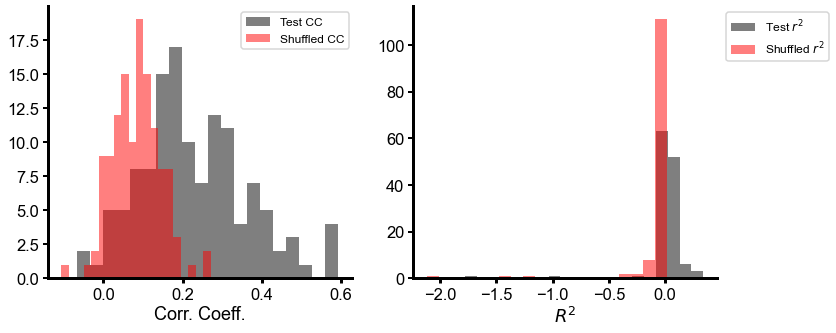

In [23]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].hist(mcc,bins=20,color='k',alpha=.5,label='Test CC')
axs[0].hist(mcc_shuff,bins=20,color='r', alpha=.5,label='Shuffled CC')
axs[0].set_xlabel('Corr. Coeff.')
axs[0].legend(bbox_to_anchor=(1.01, 1), fontsize=12)

axs[1].hist(mr2,bins=20,color='k',alpha=.5,label='Test $r^2$')
axs[1].hist(mr2_shuff,bins=20,color='r', alpha=.5,label='Shuffled $r^2$')
axs[1].set_xlabel('$R^2$')
axs[1].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
# plt.savefig(FigPath/'CC_comparison_mot_{}_dt{}.png'.format(model_type,int(1000*model_dt)), facecolor='white', transparent=True)

# GLM by hand STA

In [8]:
do_shuffle=False
bin_length=40
model_dt=.05
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

lag_max=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag_max//(1000*model_dt)); maxlag=int((lag_max//(1000*model_dt))+1)
lag_list =  np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
# print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'
perms = np.array(list(itertools.combinations(np.arange(len(titles)), 1)))
perm = perms[0]
##### Start GLM Parallel Processing #####
start = time.time()
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag

Done Loading Aligned Data
TRAIN: 3853 TEST: 1652


<ipython-input-3-fc172eb0463b>:35: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [13]:
msta = np.zeros(((len(lag_list),)+nks))
sp_smooth = np.zeros((len(lag_list),)+ model_nsp.shape[0])
pred_smooth = np.zeros((len(lag_list),)+ model_nsp.shape[0])
celln = 117
# Reshape data (video) into (T*n)xN array
for lagn,lag in enumerate(lag_list):
    rolled_vid = np.roll(model_vid_sm, lag, axis=0)
    x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
    # move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis]))

    ##### Format data #####
    # save shape of train_data for initialization
    nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]

    # Shift spikes by -lag for GLM fits
    sps_train = np.roll(train_nsp[:,celln],-lag)
    sps_test = np.roll(test_nsp[:,celln],-lag)

    # Reshape data (video) into (T*n)xN array
    # x_train = train_data.reshape(train_data.shape[0],-1)
    x_train = np.append(x_train, np.ones((x_train.shape[0],1)), axis = 1) # append column of ones for fitting intercept
    #     x_train = np.concatenate((x_train, move_train),axis=1)

    # x_test = test_data.reshape(test_data.shape[0],-1) 
    x_test = np.append(x_test,np.ones((x_test.shape[0],1)), axis = 1) # append column of ones
    #     x_test = np.concatenate((x_test, move_test),axis=1)

    # Prepare Design Matrix
    lambdas = 2**np.arange(0,16)
    nlam = len(lambdas)
    XXtr = x_train.T @ x_train
    XYtr = x_train.T @ sps_train


    # Initialze mse traces for regularization cross validation
    msetrain = np.zeros((nlam,1))
    msetest = np.zeros((nlam,1))
    w_ridge = np.zeros((x_train.shape[-1],nlam))
    # Inverse matrix for regularization 
    Cinv = np.eye(nk)
    Cinv = linalg.block_diag(Cinv,np.zeros((1, 1)))
    # loop over regularization strength
    for l in range(len(lambdas)):
        # calculate MAP estimate               
        w = np.linalg.solve(XXtr + lambdas[l]*Cinv, XYtr) # equivalent of \ (left divide) in matlab
        w_ridge[:,l] = w
        # calculate test and training rms error
        msetrain[l] = np.mean((sps_train - x_train@w)**2)
        msetest[l] = np.mean((sps_test - x_test@w)**2)

    # select best cross-validated lambda for RF
    best_lambda = np.argmin(msetest)
    w = w_ridge[:,best_lambda]
    ridge_rf = w_ridge[:,best_lambda]
    sta_all = np.reshape(w[:-1],nks)
    msta[lagn] = sta_all
    # predicted firing rate
    sp_pred = x_test@ridge_rf
    # bin the firing rate to get smooth rate vs time
    sp_smooth = (np.convolve(sps_test, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    pred_smooth = (np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt)
    # a few diagnostics
    err = np.mean((sp_smooth-pred_smooth)**2)
    cc = np.corrcoef(sp_smooth, pred_smooth)
    cc_all = cc[0,1]

Done Loading Aligned Data
TRAIN: 3853 TEST: 1652


<ipython-input-3-fc172eb0463b>:35: RuntimeWarning: invalid value encountered in true_divide
  data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)


In [32]:
model_vid_sm.shape

(22326, 20, 30)

In [12]:
celln = 51
lag_list =  np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
# print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'
# perms = np.array(list(itertools.combinations(np.arange(len(titles)), 1)))
# perm = perms[0]
##### Start GLM Parallel Processing #####
start = time.time()
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag

msta = np.zeros(((len(lag_list),)+nks))
# Reshape data (video) into (T*n)xN array
for lagn,lag in enumerate(lag_list):
    rolled_vid = np.roll(model_vid_sm, lag, axis=0)
    x = rolled_vid.reshape(model_vid_sm.shape[0],-1)
    sp = model_nsp[:,celln].copy()
#     sp = np.roll(sp, -lag)
    sta = x.T @ sp
    sta = np.reshape(sta, nks)
    nsp = np.sum(sp)
    if nsp > 0:
        sta = sta/nsp
    else:
        sta = np.nan
    msta[lagn] = sta
    
    


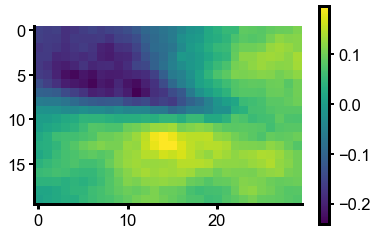

In [13]:
plt.imshow(sta.reshape(nks))
plt.colorbar()

In [10]:
sf = 4
msta_up = np.zeros((msta.shape[0],sf*msta.shape[-2],sf*msta.shape[-1]))
for n in range(msta.shape[0]):
#     for t in range(msta.shape[1]):
    msta_up[n] = cv2.resize(msta[n],(sf*msta.shape[-1],sf*msta.shape[-2]))


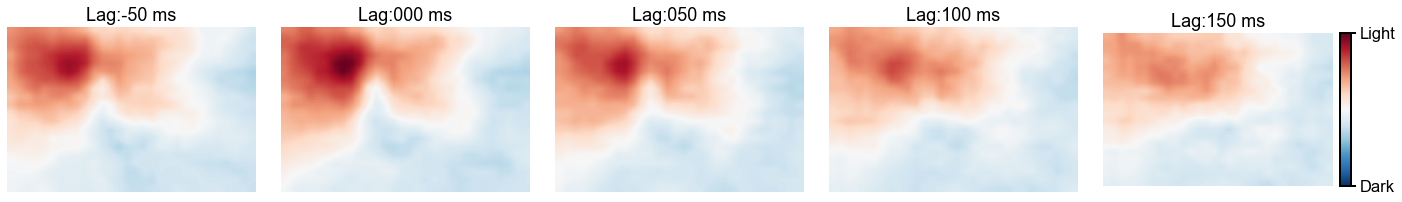

In [11]:
celln = 25# np.argmax(mcc)
bin_length=40
# fig, axs = plt.subplots(1,figsize=(15,5))
# predcell = mpred[celln]/model_dt
# nspcell = msp[celln]/model_dt
# msp_smooth=(np.convolve(msp[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# pred_smooth=(np.convolve(mpred[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# axs.plot(np.arange(len(msp_smooth))*model_dt,msp_smooth,'k',label='test FR')
# axs.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
# axs.set_xlabel('Time (s)')
# axs.set_ylabel('Firing Rate (spks/s)')
# axs.legend()
# axs.set_title('Smoothed FRs')
# plt.tight_layout()
# fig.savefig(FigPath/'Example_TestPred_{}_cell{}.png'.format(stim_type,celln), facecolor='white', transparent=True)
n=1; axn=4
fig, axs = plt.subplots(1,nt_glm_lag, figsize=((20,5))) 
crange = np.max(np.abs(msta))
for n in range(len(lag_list)):
    img = axs[n].imshow(msta_up[n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    axs[n].axis('off')
    axs[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    axs[n].axis('off')
cbar = add_colorbar(img)
cbar.set_ticks([-crange,crange])
cbar.set_ticklabels(['Dark','Light'])
plt.tight_layout()
# fig.savefig(FigPath/'Example_STAnonGLM_{}_cell{}.pdf'.format(stim_type,celln), facecolor='white', transparent=True)